<a href="https://colab.research.google.com/github/vasisvaran/Deep-Learning-Papers-Reading-Roadmap/blob/master/Week7/Assignment/MSDS453_Assignment_03_v25_20231025_KG_Ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## MSDS453 - Research Assignment 03 - Ontology Plus Context and Modeling

Take the ontology that you developed in week 6 and consider how your ten chosen documents for this quarter's class corpus map to that ontology.

Protégé is a tool that takes inputs for a human-created Ontology and creates a visualization.

Use Python algorithms to generate Knowledge Graphs from your documents.

TensorFlow Bidirectional RNN Model

In [3]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

<div class="alert alert-block alert-danger">
<b>Required Installation: en_core_web_lg</b><br>"python -m spacy download en_core_web_lg"<br><br>English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer<br>
    <b>https://spacy.io/models/en#en_core_web_lg </b>
</div>

## Requires Restart Of Runtime After Installation

In [4]:
!python -m spacy download en_core_web_lg -q

2023-11-03 18:22:08.730757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 18:22:08.730826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 18:22:08.730872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 18:22:09.963195: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [5]:
nlp = spacy.load('en_core_web_lg')

### Mount Google Drive to Colab Environment

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### NLTK Downloads

In [7]:
# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

True

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [8]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

In [9]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [10]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Data Wrangling Utility Functions

In [11]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc):
    doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

## Knowledge Context Graph Functions

In [12]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')

def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')

    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)

    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')

def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []

    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()

        output.append(rows)
        sources = set(rows.target).union(set(rows.source))

    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))

    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)

    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)

    plt.show()

def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

## Entity Extraction Functions

In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},
                {'POS':'ADJ','OP':"?"}]
        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

## Visualization Utility Functions

In [14]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

## Exploratory Data Analysis

In [17]:
movie_df = pd.read_csv("kg_ex3_raw_openai.csv")
movie_df.head(3)

source     edge                         target
0  average viewer  expects  nonsensical, hole-filled plot
1  average viewer  expects              horrible dialogue
2            they  go with                      territory

## Knowledge Graph Extraction

### Create DataFrame (Source, Target, Edge)

In [18]:
kg_df = pd.DataFrame({'source': movie_df['source'], 'target': movie_df['target'], 'edge': movie_df['edge']})

### Knowledge Graph Preprocessing (Lowercase, Remove Empty Spaces)

In [19]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.source != kg_df.target]

In [20]:
kg_df.head(6).T

0                  1          2  \
source                 average viewer     average viewer       they   
target  nonsensical, hole-filled plot  horrible dialogue  territory   
edge                          expects            expects    go with   

                 3                                                  4  \
source  20 minutes                                       what matters   
target    my brain  the cars, car chases, a few mooks dying and th...   
edge         tried                                                are   

                                  5  
source                        genre  
target  young male's middle regions  
edge                    is aimed at

In [21]:
kg_df.shape

(230, 3)

In [23]:
kg_df_temp = pd.DataFrame({'source': kg_df['source'], 'edge': kg_df['edge'], 'target': kg_df['target'] })
kg_df_temp.to_excel("kg_ex3.xlsx")
kg_df_temp

source             edge  \
0    average viewer          expects   
1    average viewer          expects   
2              they          go with   
3        20 minutes            tried   
4      what matters              are   
..              ...              ...   
225  the soundtrack               is   
226  the soundtrack          fits in   
227              it           is not   
228             you  are looking for   
229             you             give   

                                                target  
0                        nonsensical, hole-filled plot  
1                                    horrible dialogue  
2                                            territory  
3                                             my brain  
4    the cars, car chases, a few mooks dying and th...  
..                                                 ...  
225                                             funky)  
226                           perfectly with the film)  
227                                        shakespeare  
228                                 a nicely shot film  
229                                           it a try  

[230 rows x 3 columns]

In [24]:
# Perform custom cleaning before plotting knowledge graphs
source_list = ['']
target_list = ['11']
edge_list =['\'s']

for item in source_list:
  kg_df = kg_df[kg_df.source != item]

for item in target_list:
  kg_df = kg_df[kg_df.target != item]

for item in edge_list:
  kg_df = kg_df[kg_df.edge != item]

In [25]:
kg_df

source                                             target  \
0    average viewer                      nonsensical, hole-filled plot   
1    average viewer                                  horrible dialogue   
2              they                                          territory   
3        20 minutes                                           my brain   
4      what matters  the cars, car chases, a few mooks dying and th...   
..              ...                                                ...   
225  the soundtrack                                             funky)   
226  the soundtrack                           perfectly with the film)   
227              it                                        shakespeare   
228             you                                 a nicely shot film   
229             you                                           it a try   

                edge  
0            expects  
1            expects  
2            go with  
3              tried  
4                are  
..               ...  
225               is  
226          fits in  
227           is not  
228  are looking for  
229             give  

[228 rows x 3 columns]

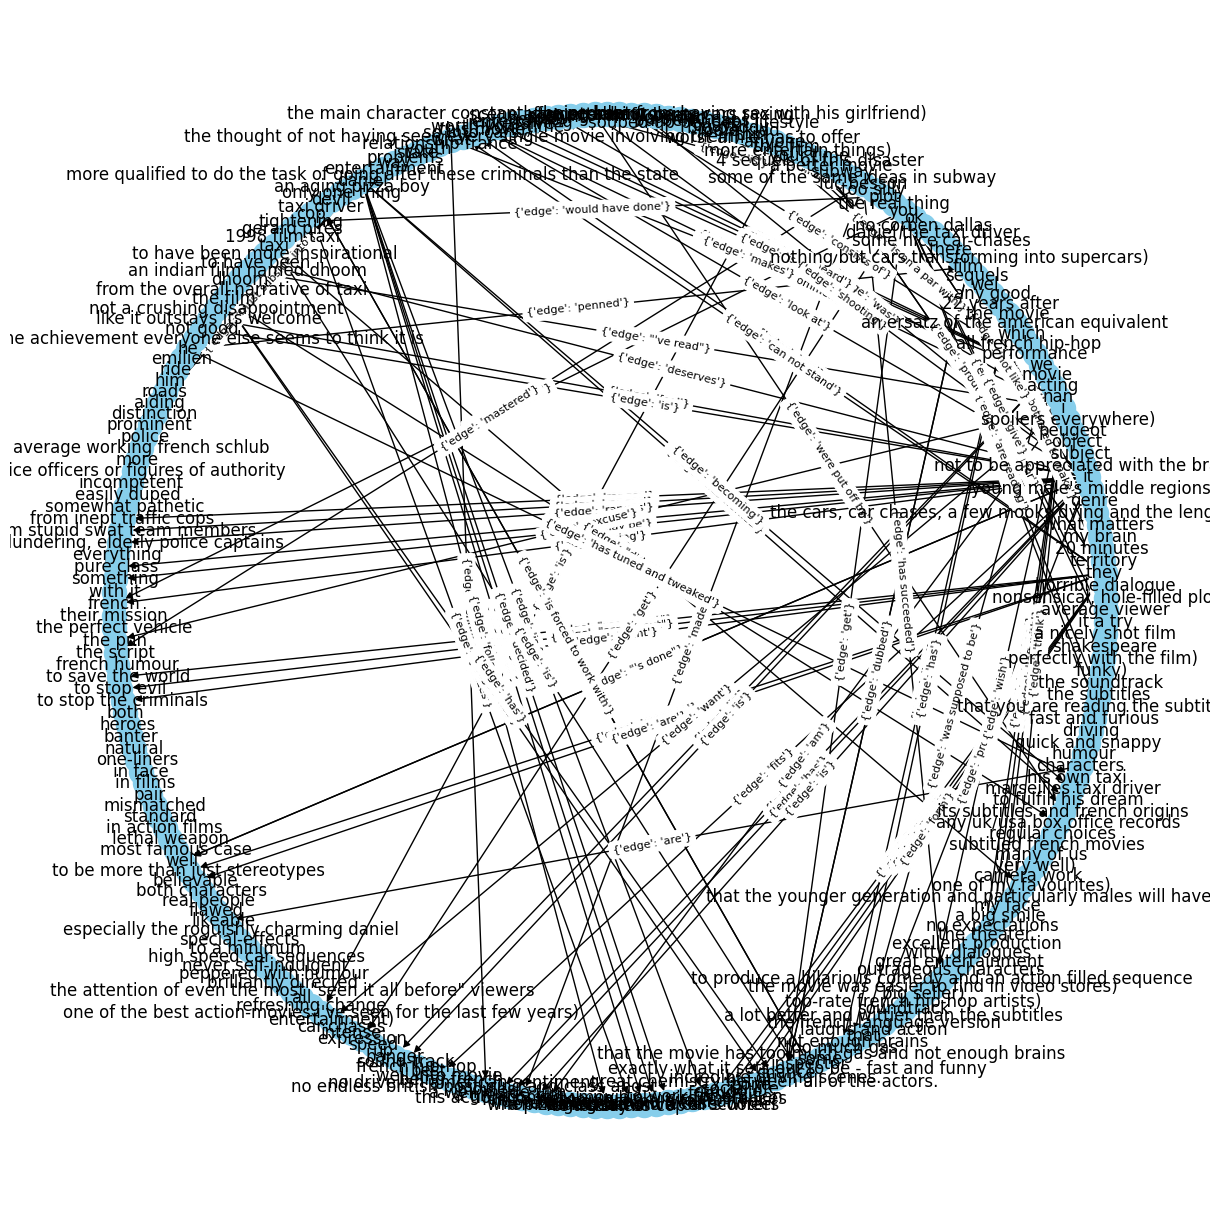

In [26]:
plot_graph(kg_df, use_circular=True, show_edges=True)

### Top 10 source, target, and edge parameters

In [27]:
kg_df['source'].value_counts().nlargest(10)

it            24
i             21
you           16
they          15
daniel        14
movie          6
what           6
the film       5
luc besson     5
subject        4
Name: source, dtype: int64

In [28]:
kg_df['target'].value_counts().nlargest(10)

it                     6
film                   4
object                 4
relationship france    3
movie                  3
prominent              3
taxi driver            3
chance                 3
great entertainment    3
well                   3
Name: target, dtype: int64

In [29]:
kg_df['edge'].value_counts().nlargest(10)

is                  48
are                 10
has                  8
have                 4
come across as       4
verb                 4
was                  4
coming across as     3
ranges               3
want                 3
Name: edge, dtype: int64

### Plot graphs for top 10 source items

Plotting knowledge graph of "source" token "it":


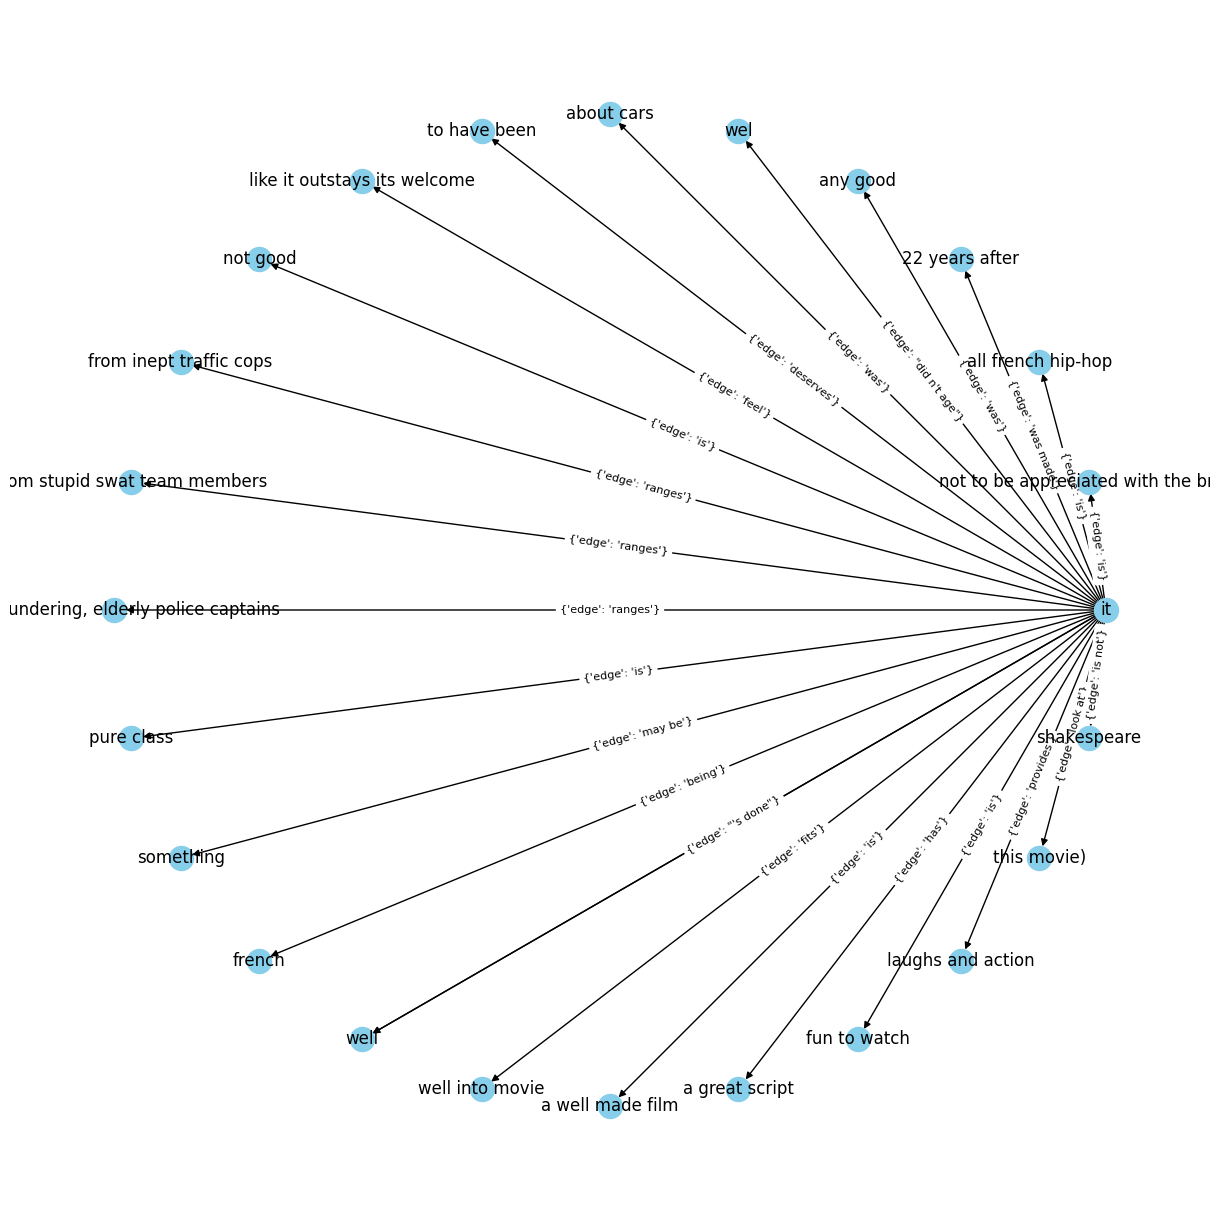

Plotting knowledge graph of "source" token "i":


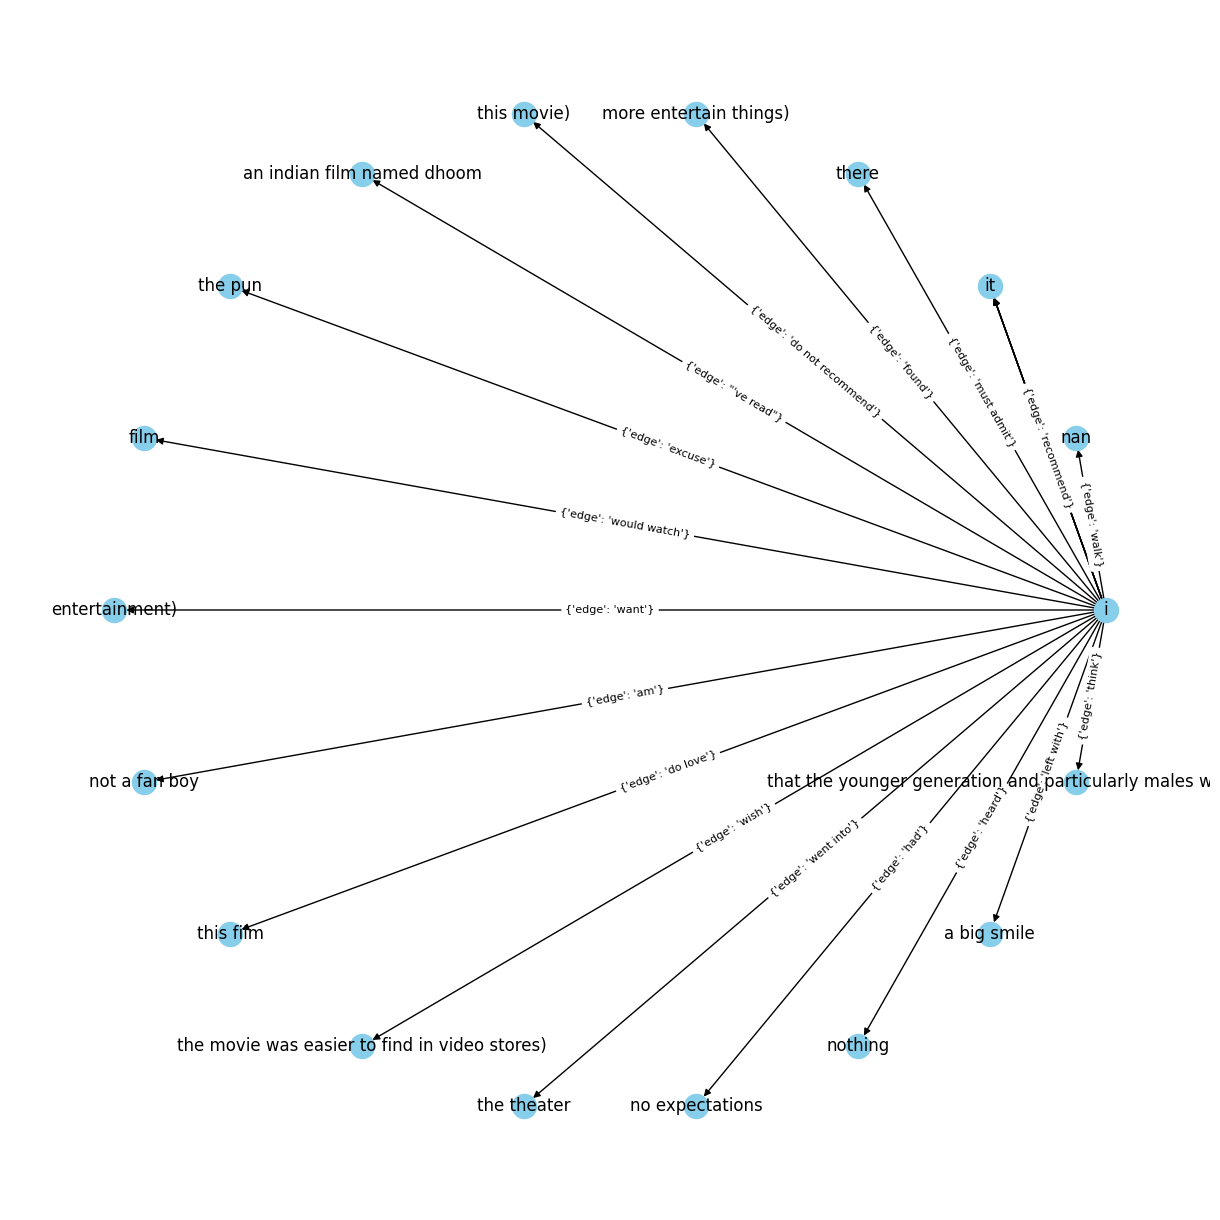

Plotting knowledge graph of "source" token "you":


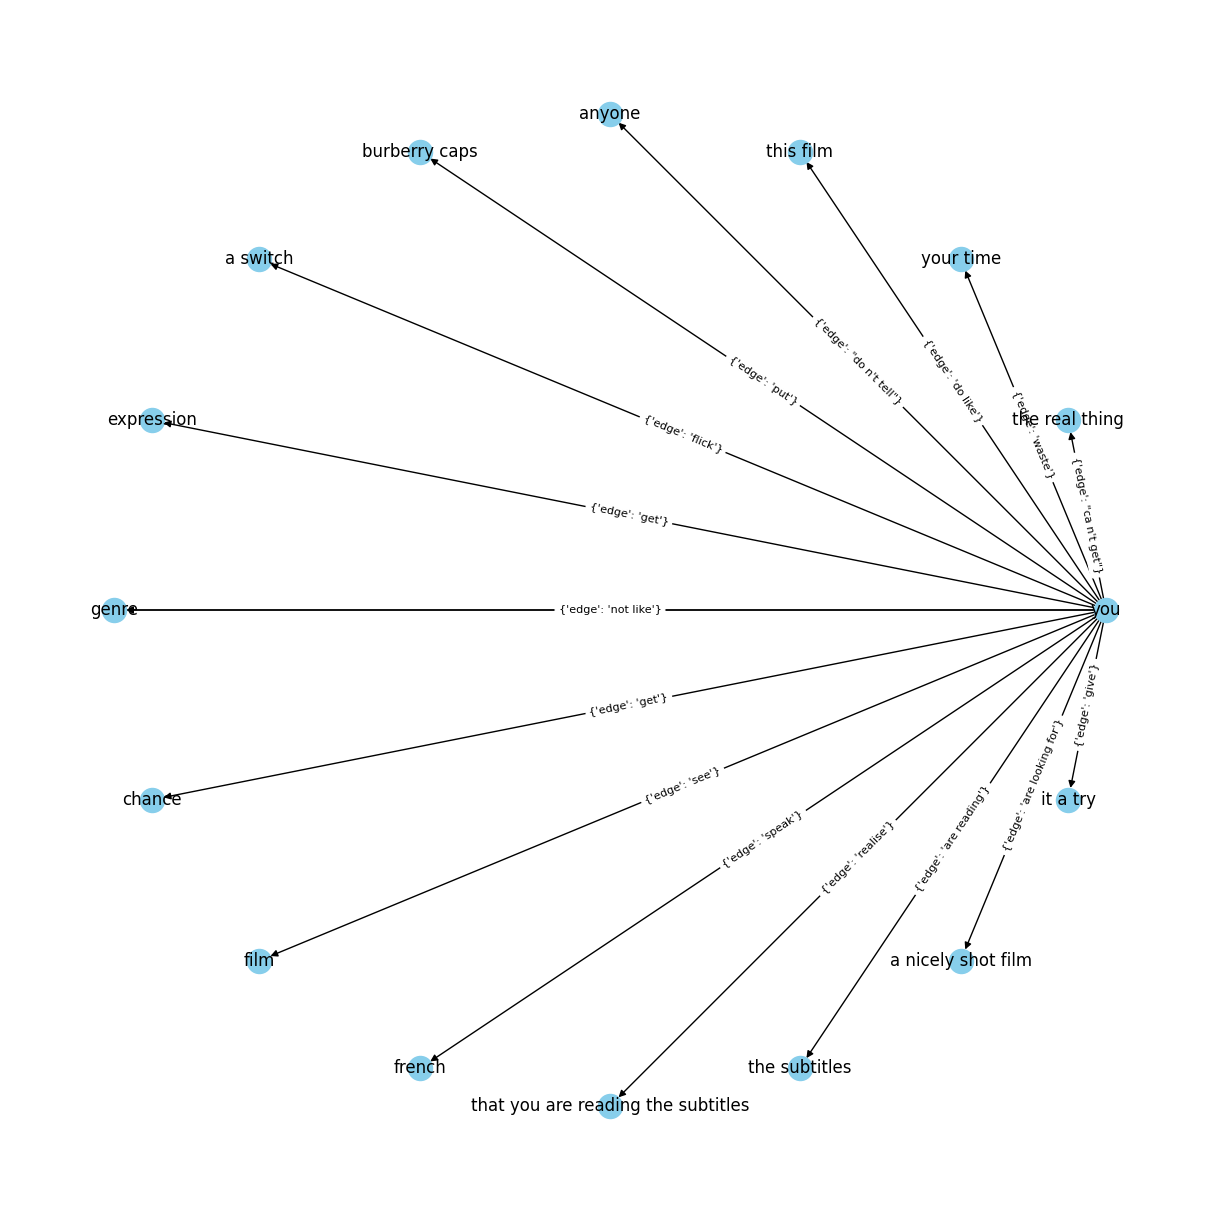

Plotting knowledge graph of "source" token "they":


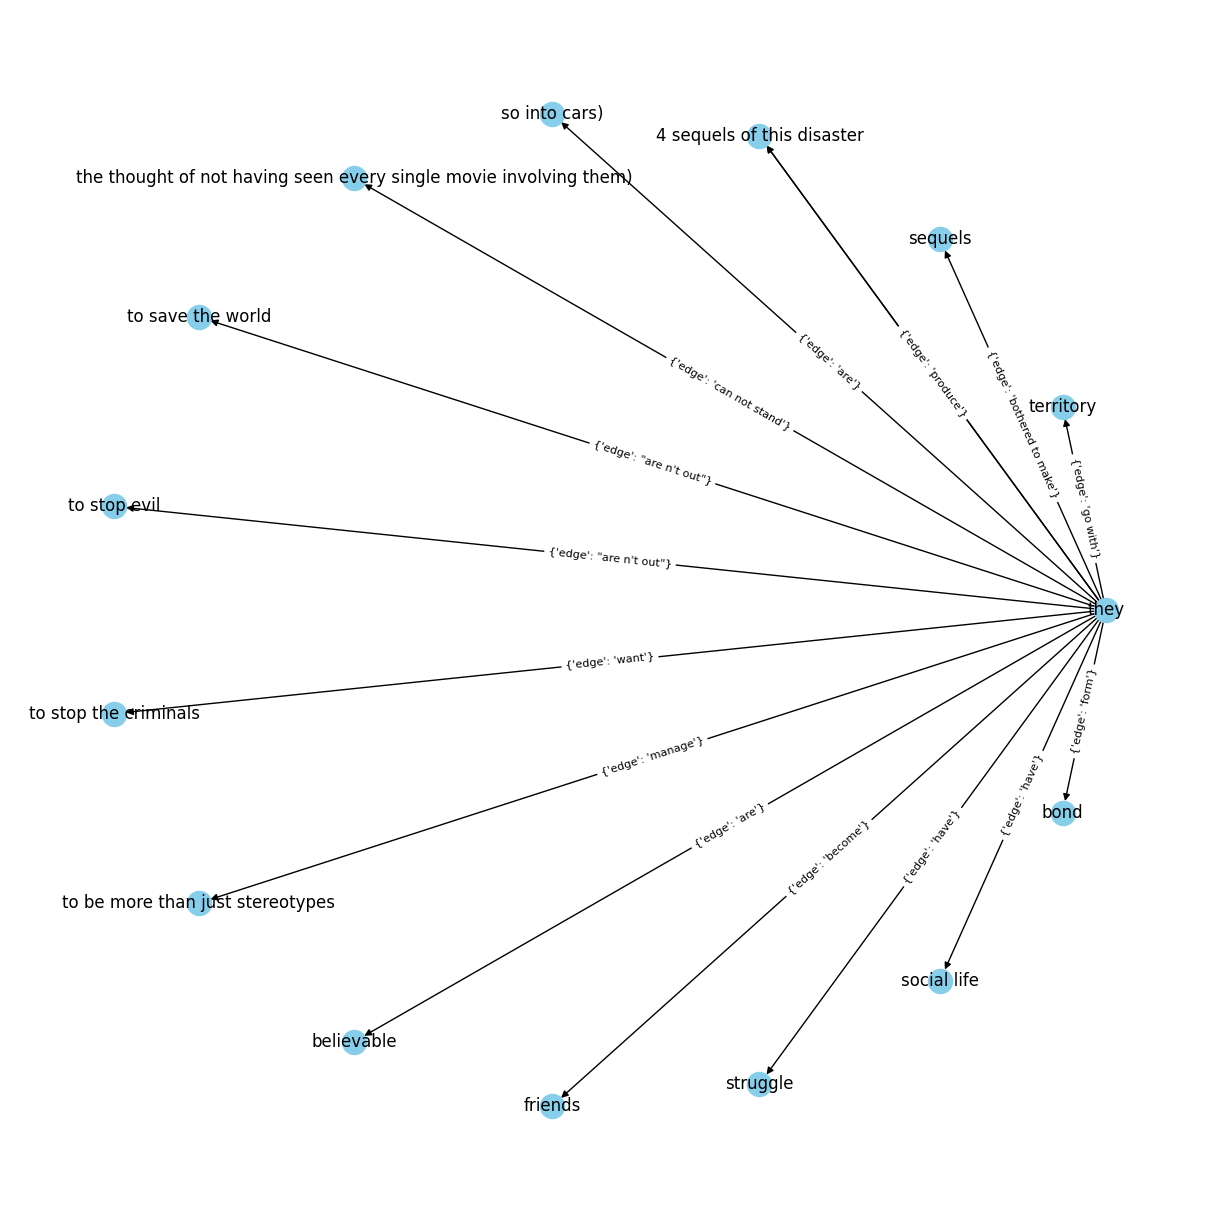

Plotting knowledge graph of "source" token "daniel":


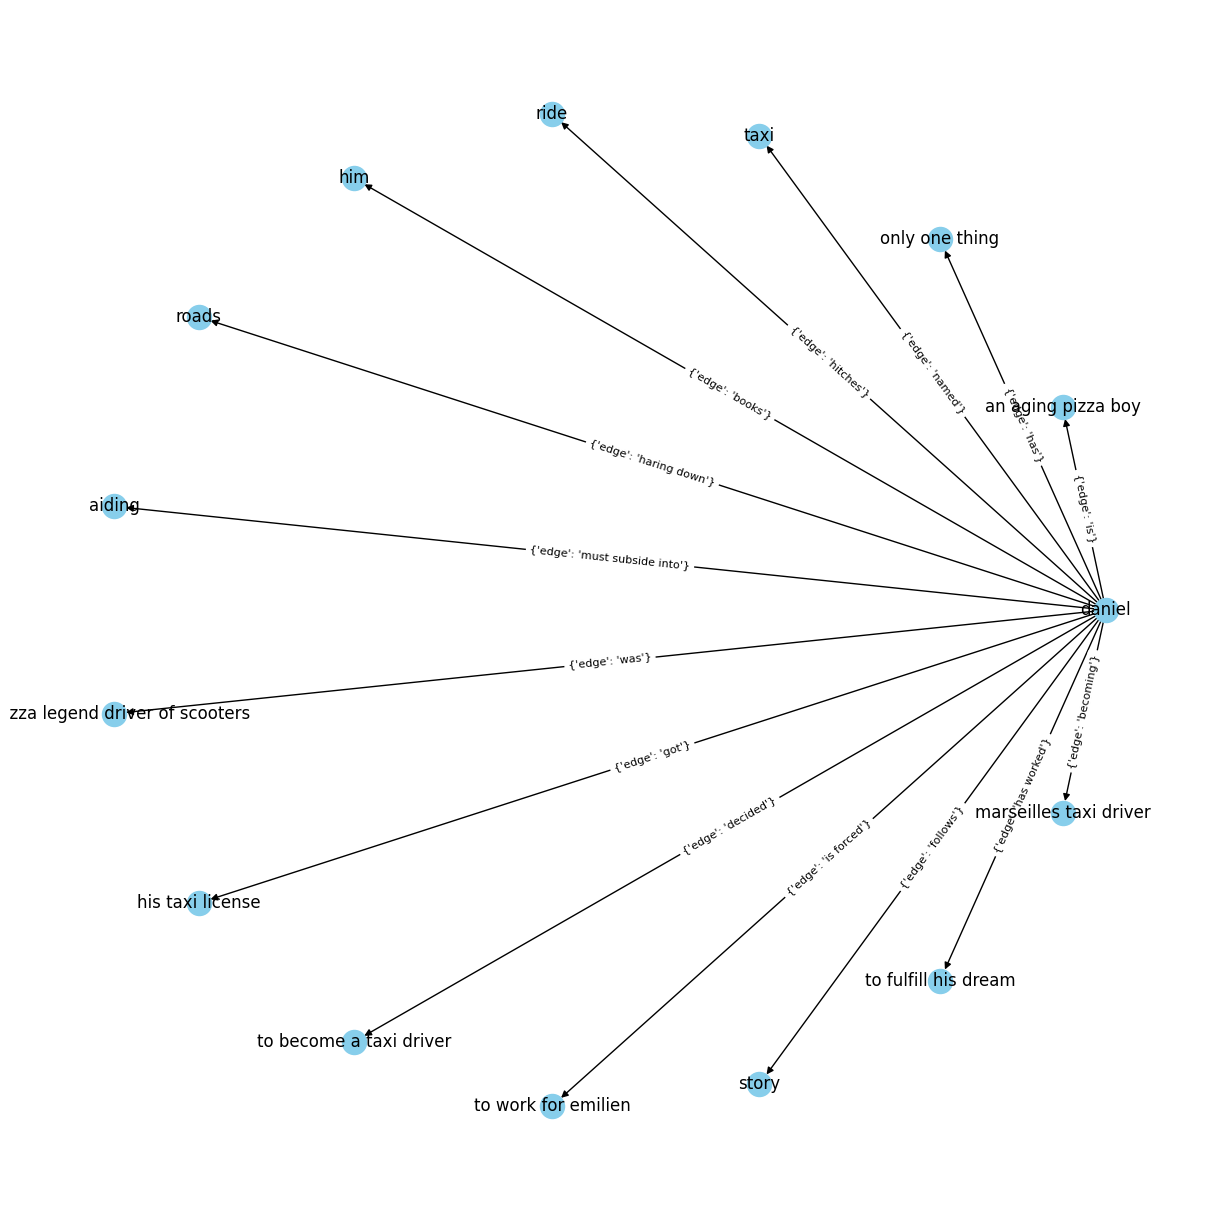

Plotting knowledge graph of "source" token "movie":


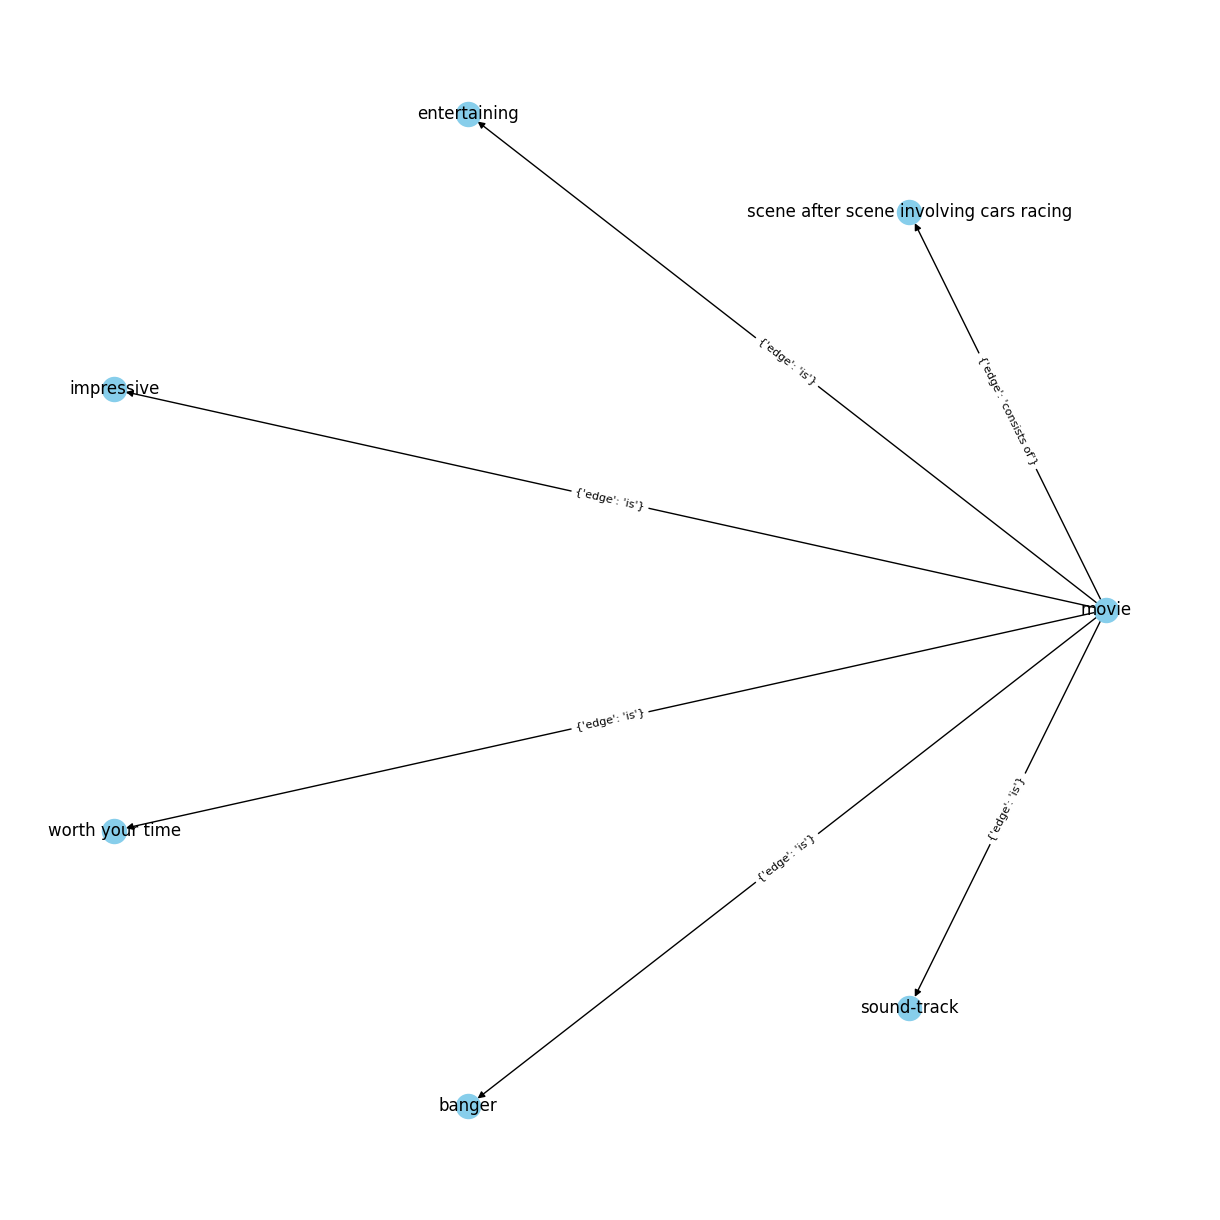

Plotting knowledge graph of "source" token "what":


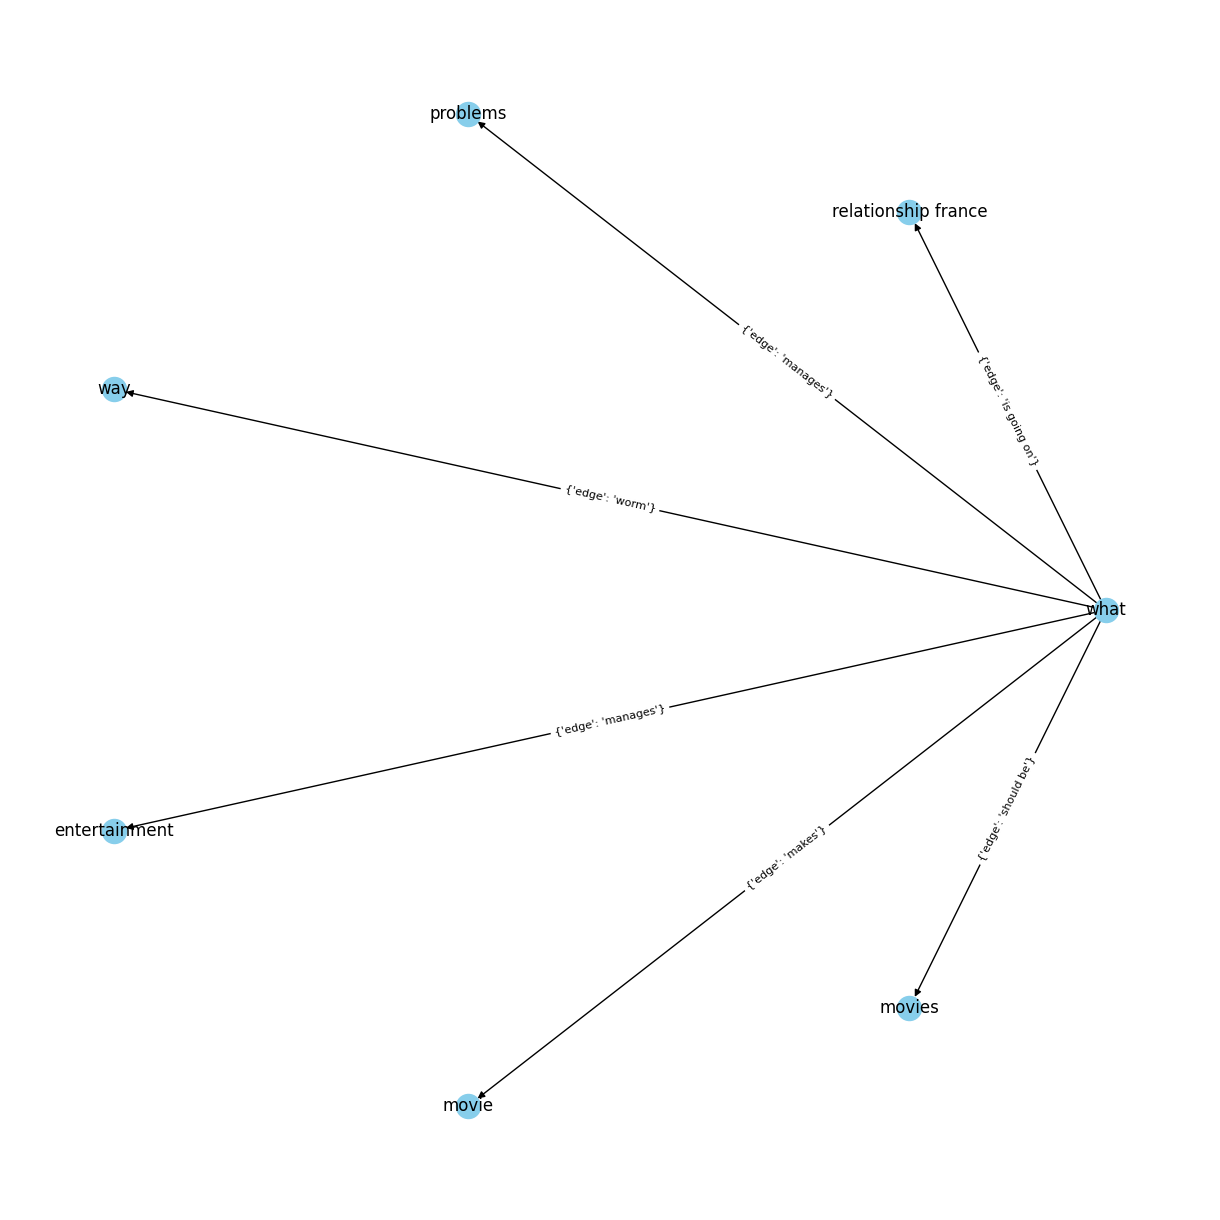

Plotting knowledge graph of "source" token "the film":


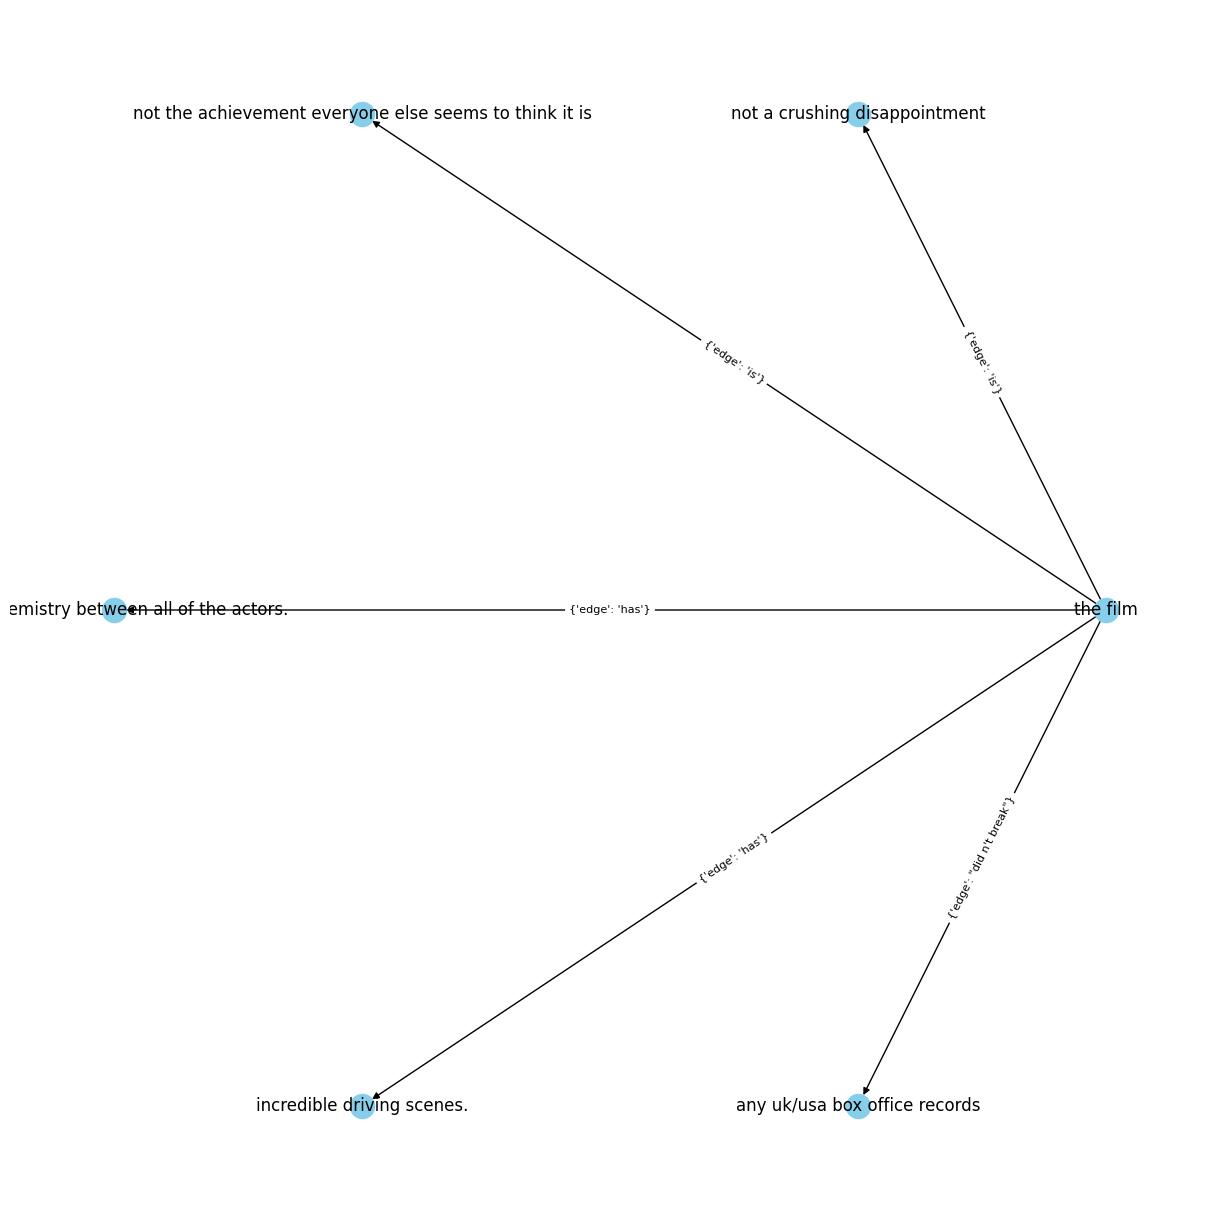

Plotting knowledge graph of "source" token "luc besson":


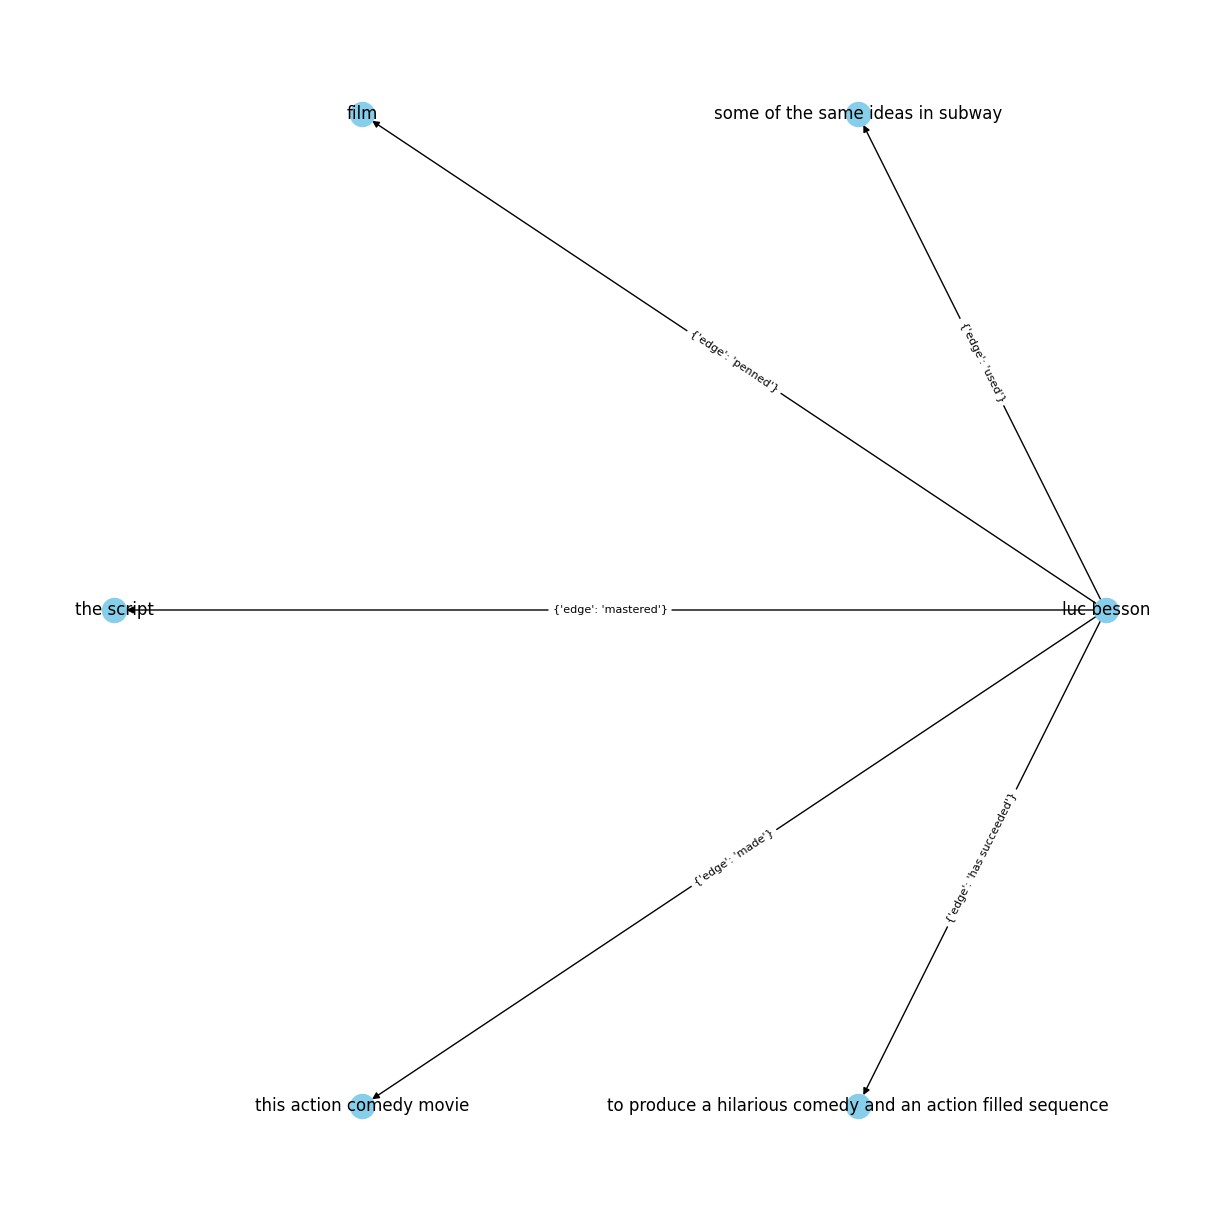

Plotting knowledge graph of "source" token "subject":


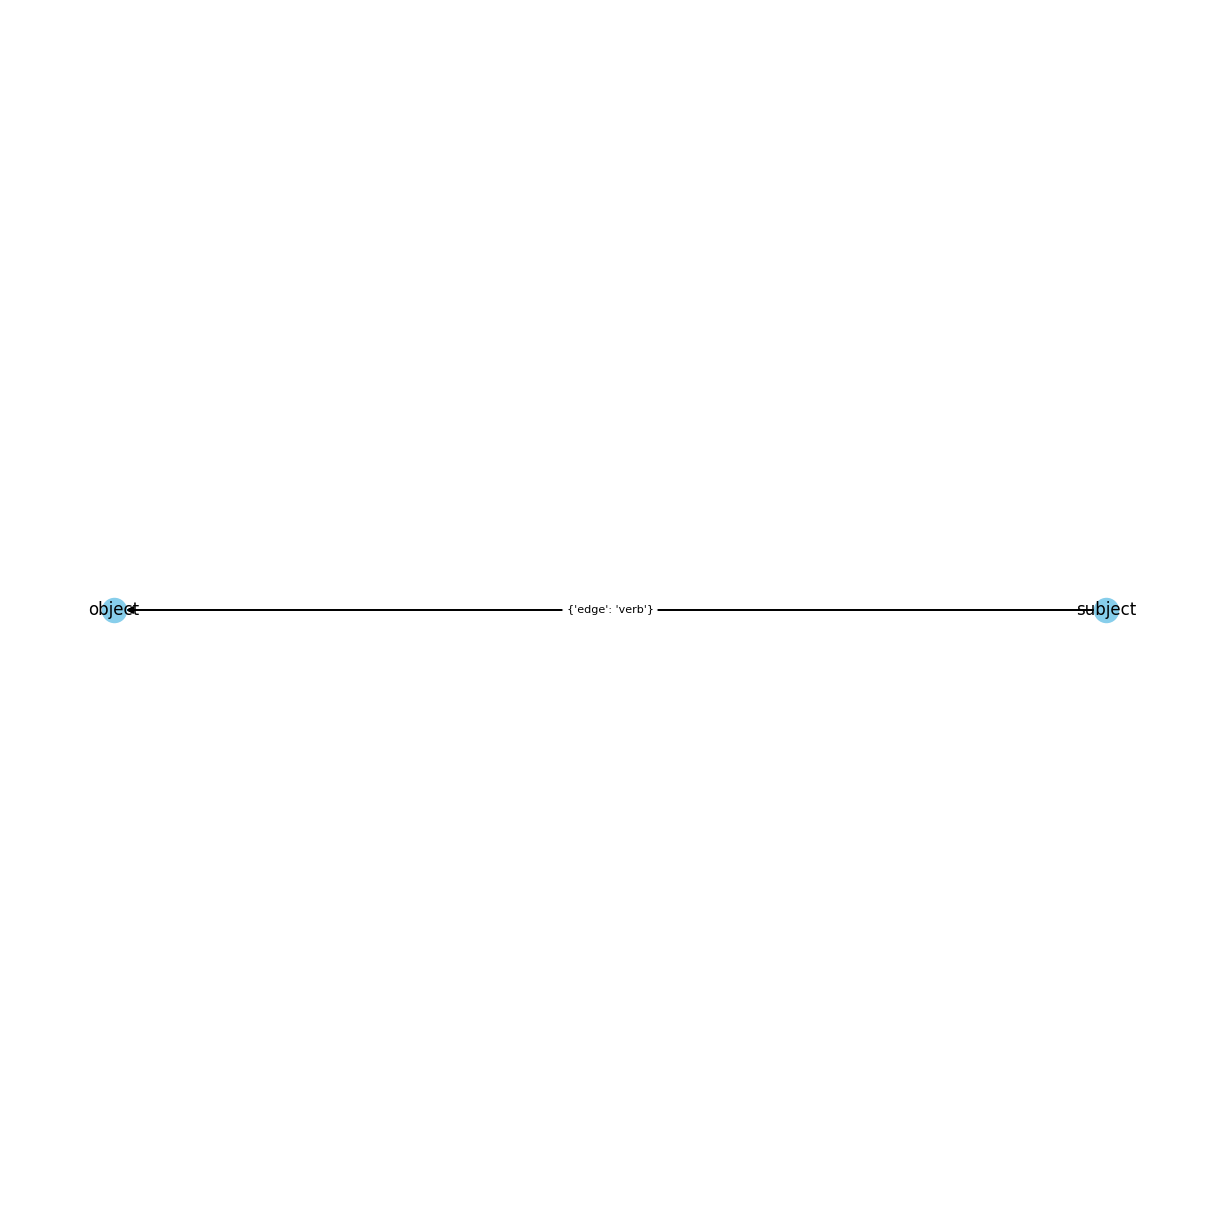

Plotting knowledge graph of "target" token "it":


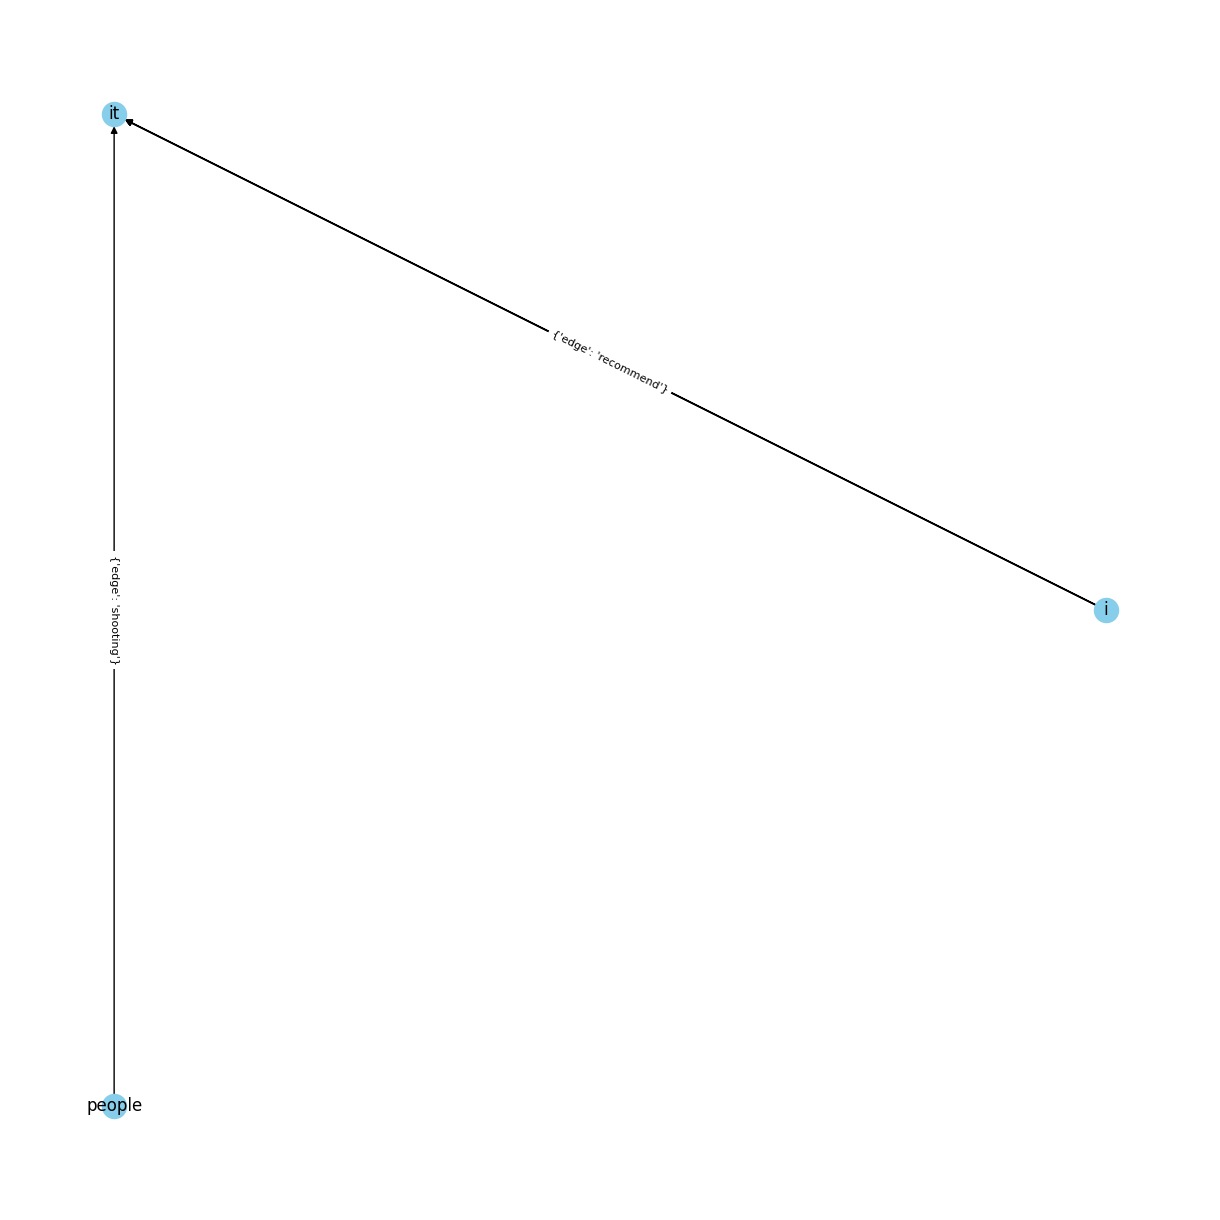

Plotting knowledge graph of "target" token "film":


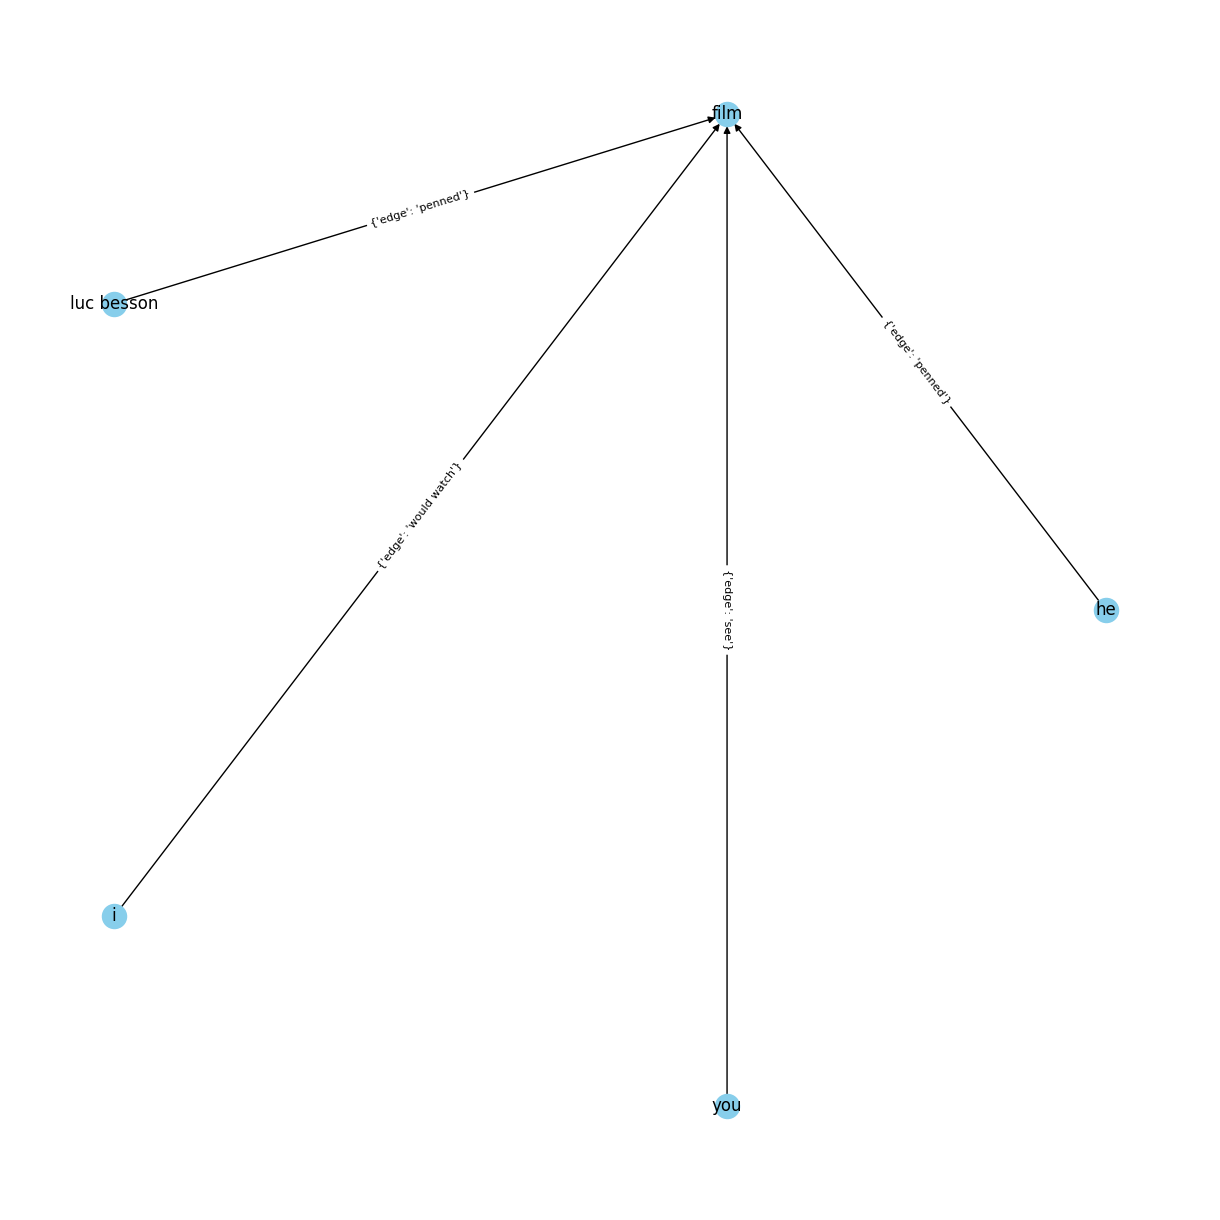

Plotting knowledge graph of "target" token "object":


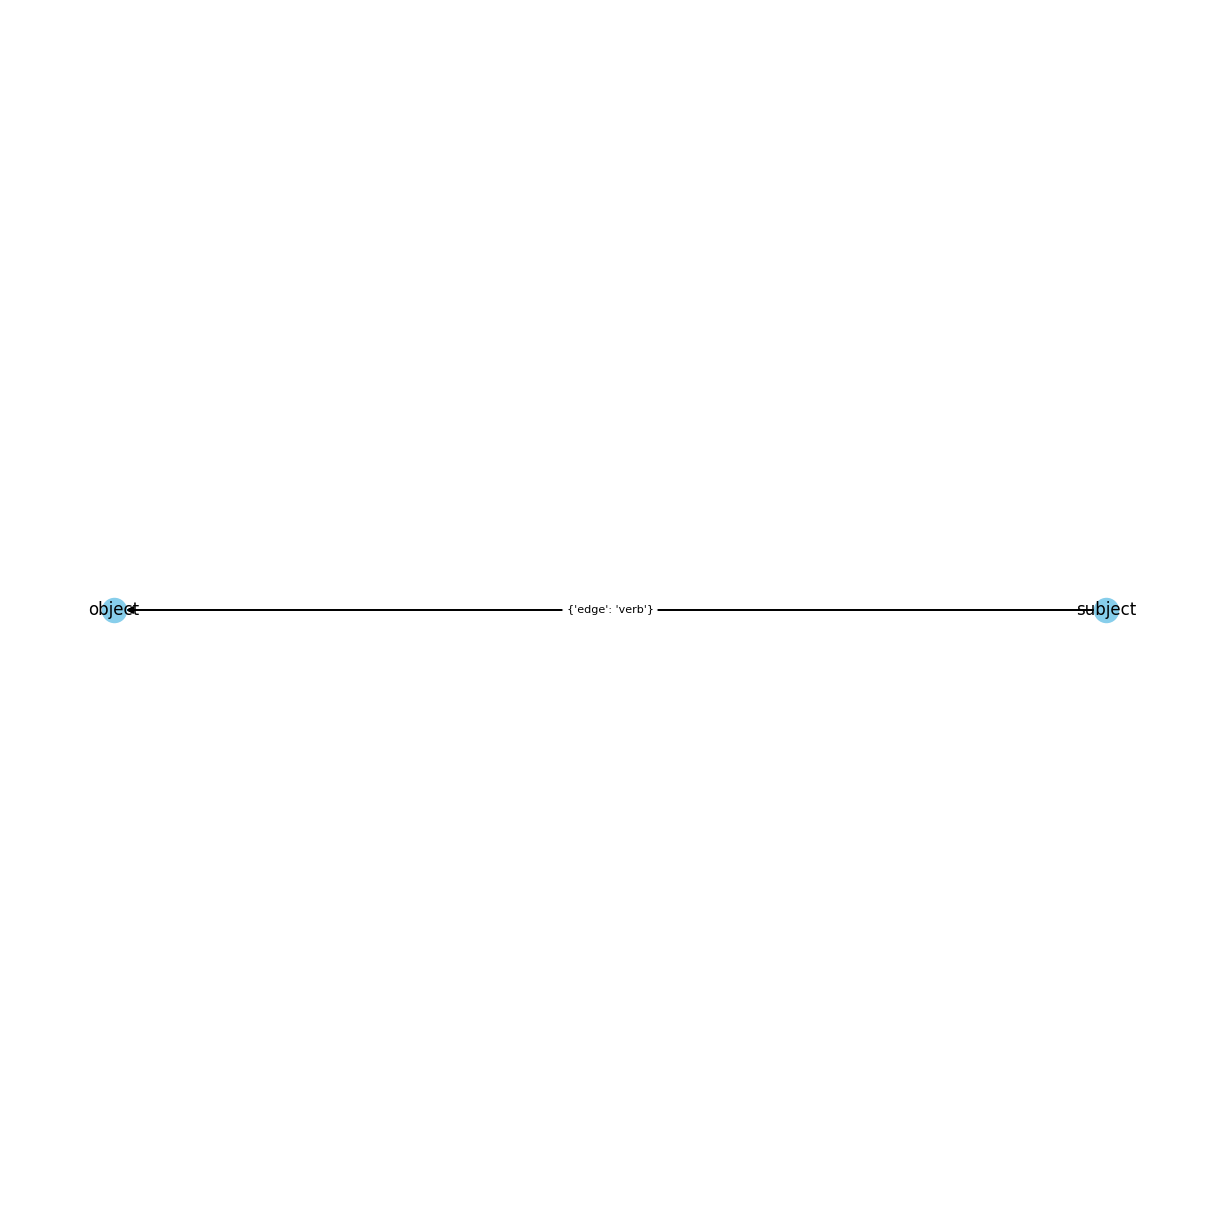

Plotting knowledge graph of "target" token "relationship france":


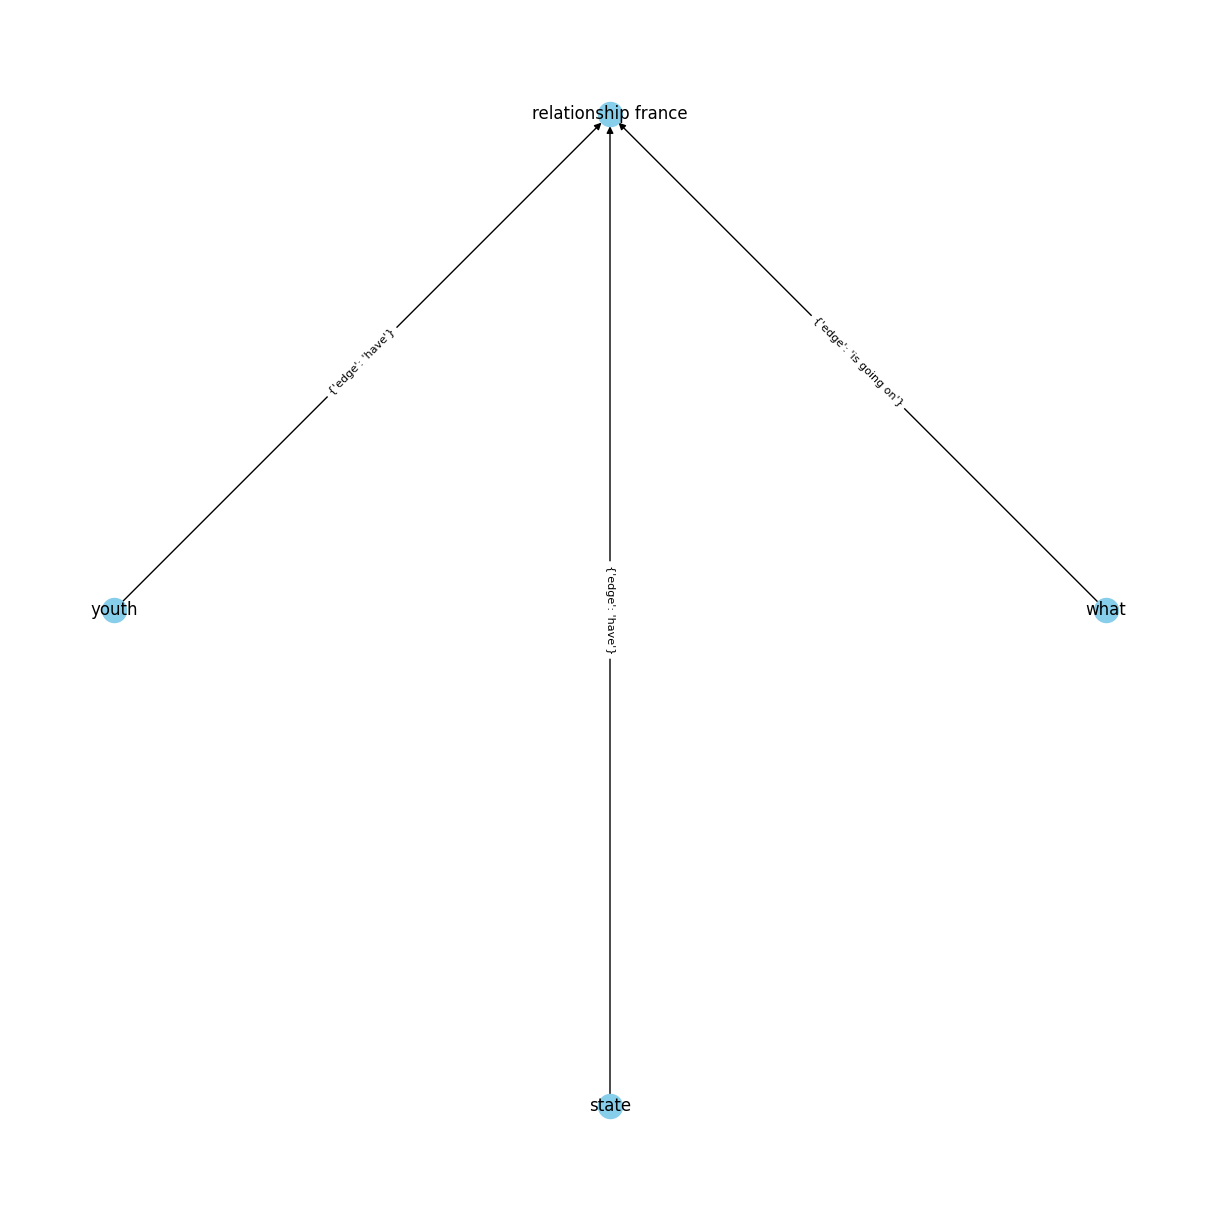

Plotting knowledge graph of "target" token "movie":


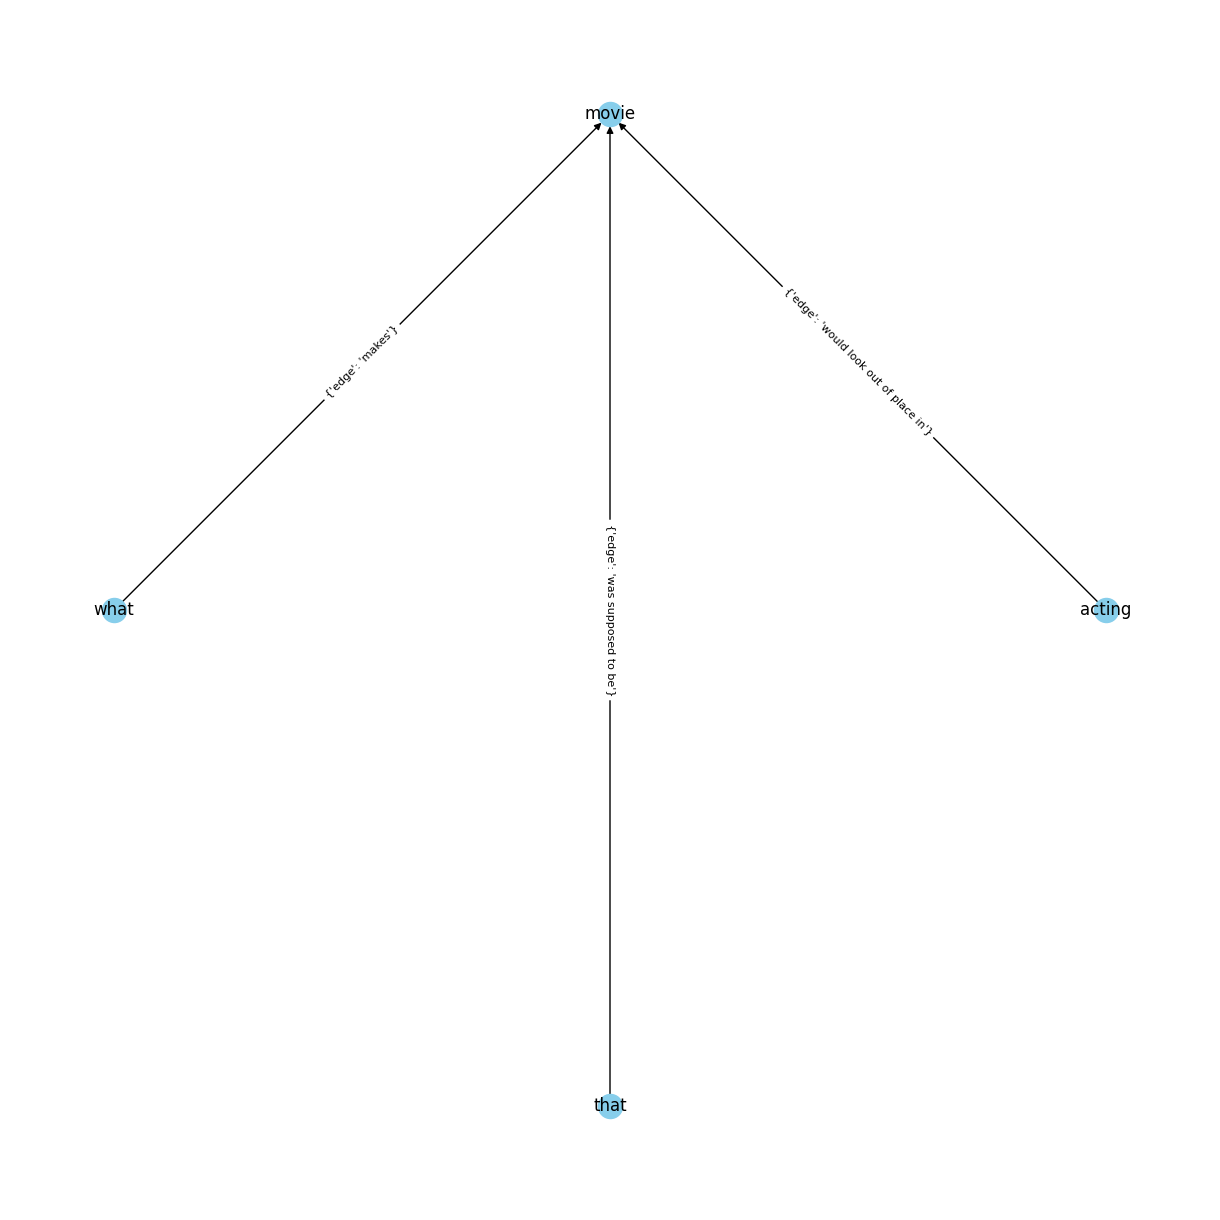

Plotting knowledge graph of "target" token "prominent":


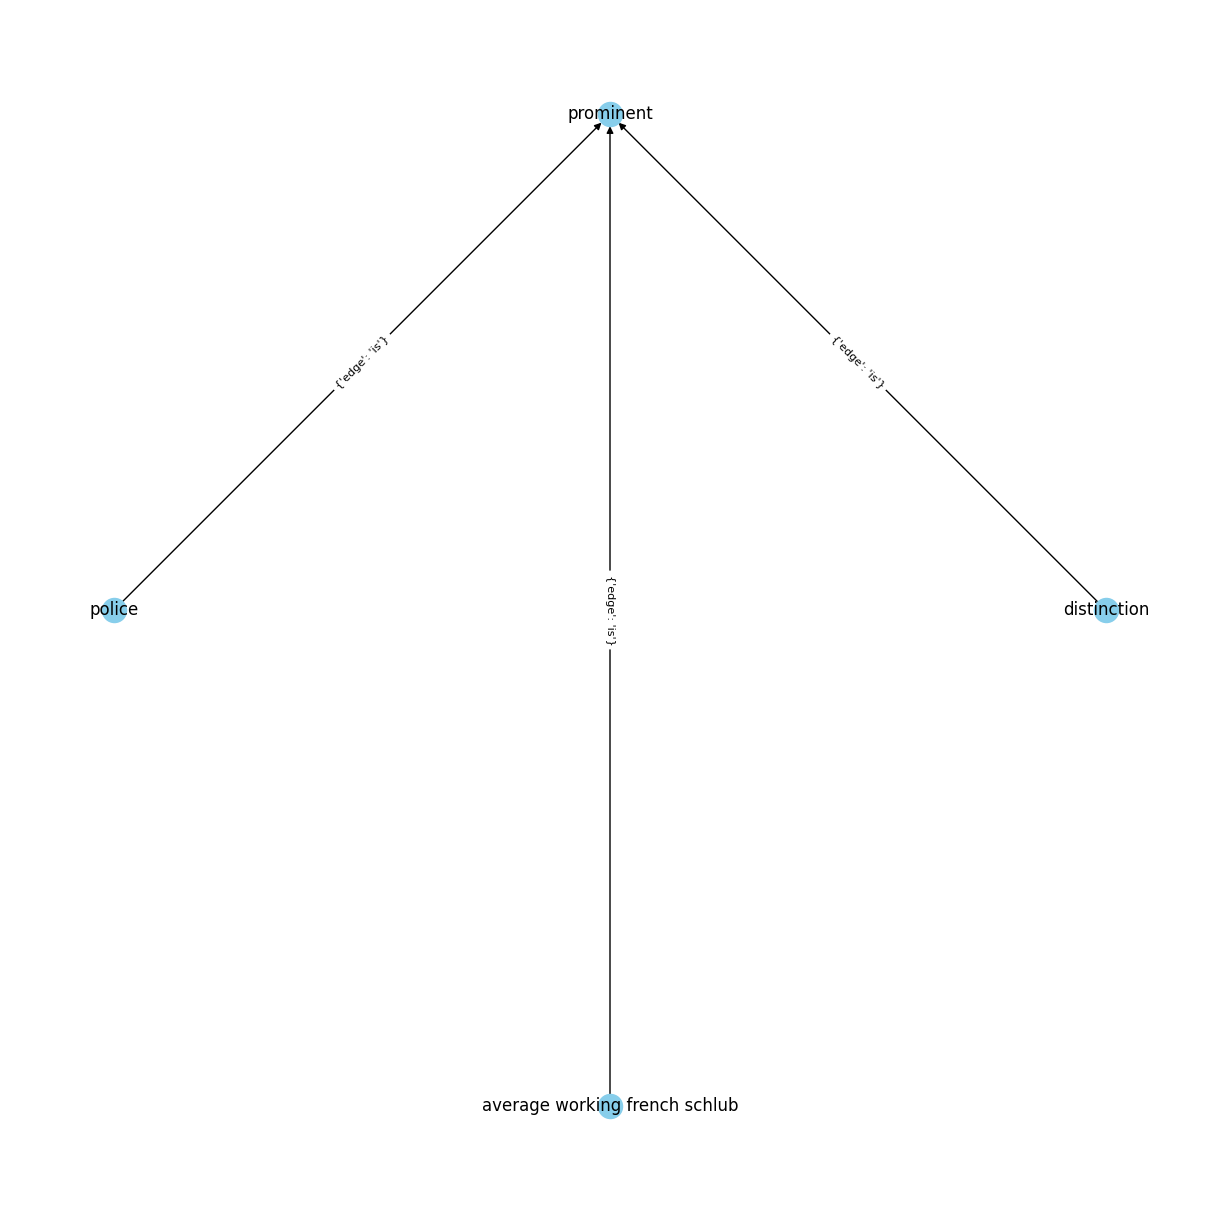

Plotting knowledge graph of "target" token "taxi driver":


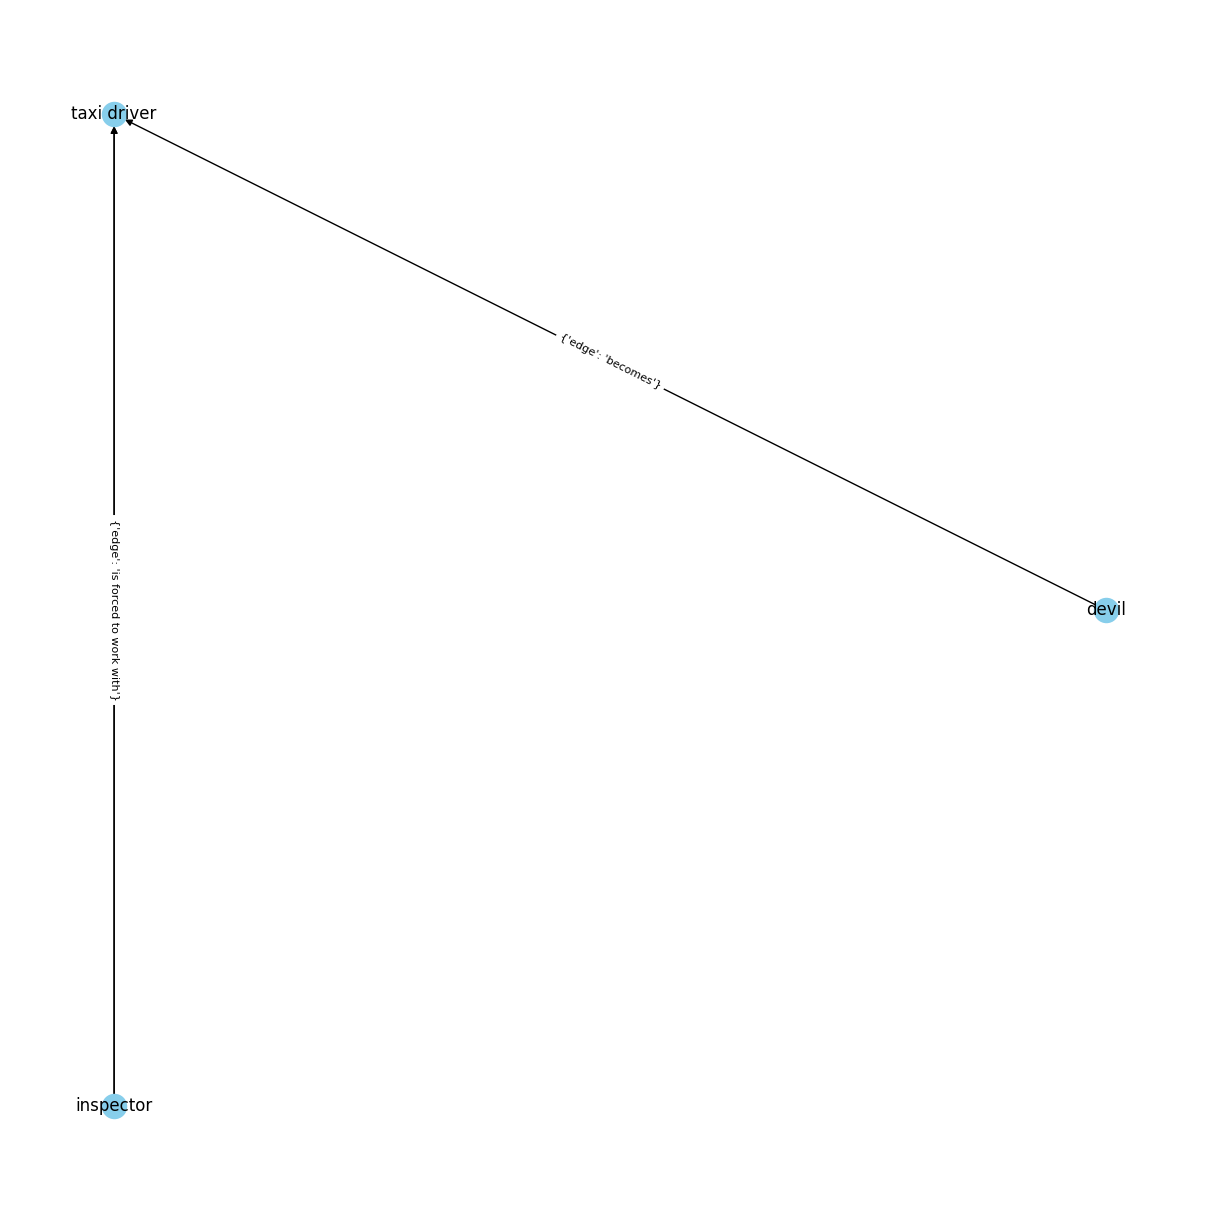

Plotting knowledge graph of "target" token "chance":


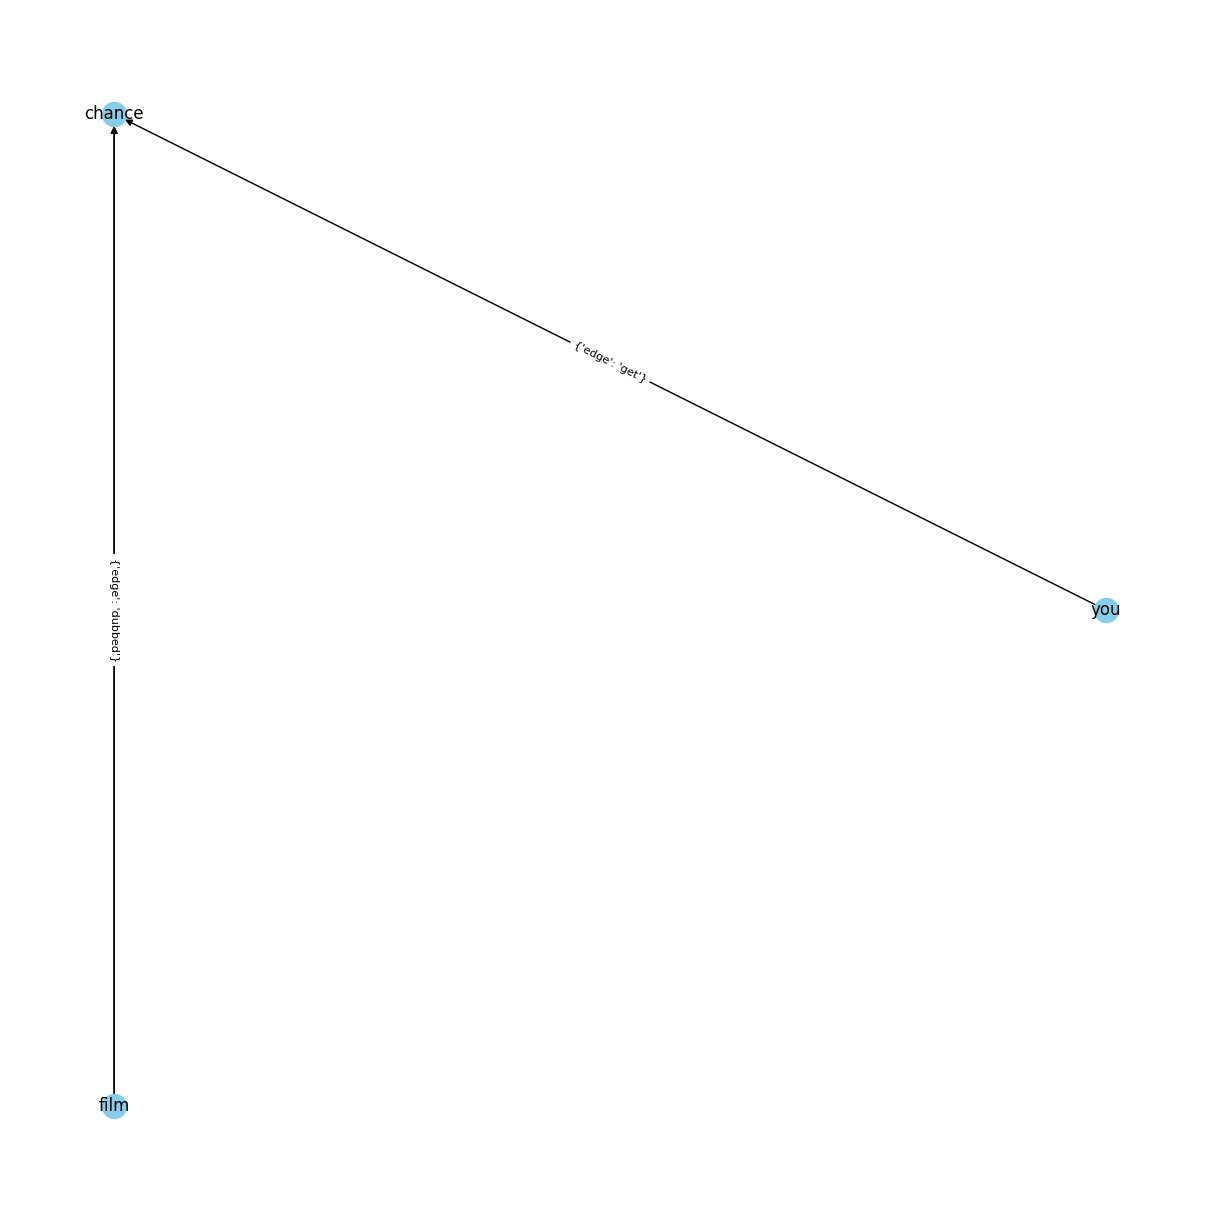

Plotting knowledge graph of "target" token "great entertainment":


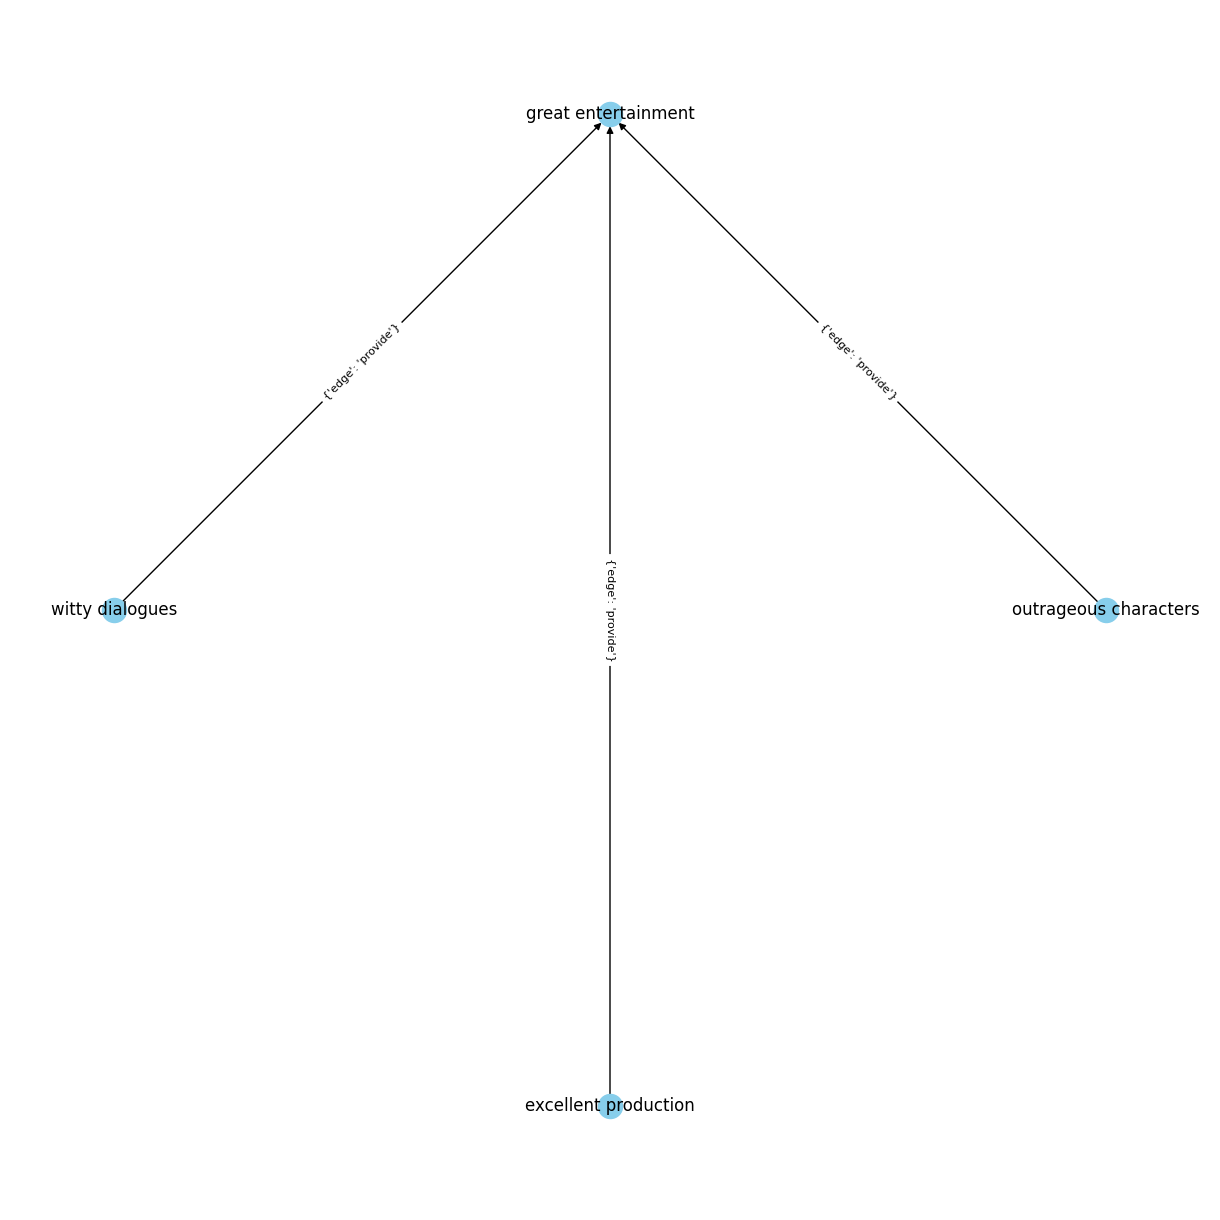

Plotting knowledge graph of "target" token "well":


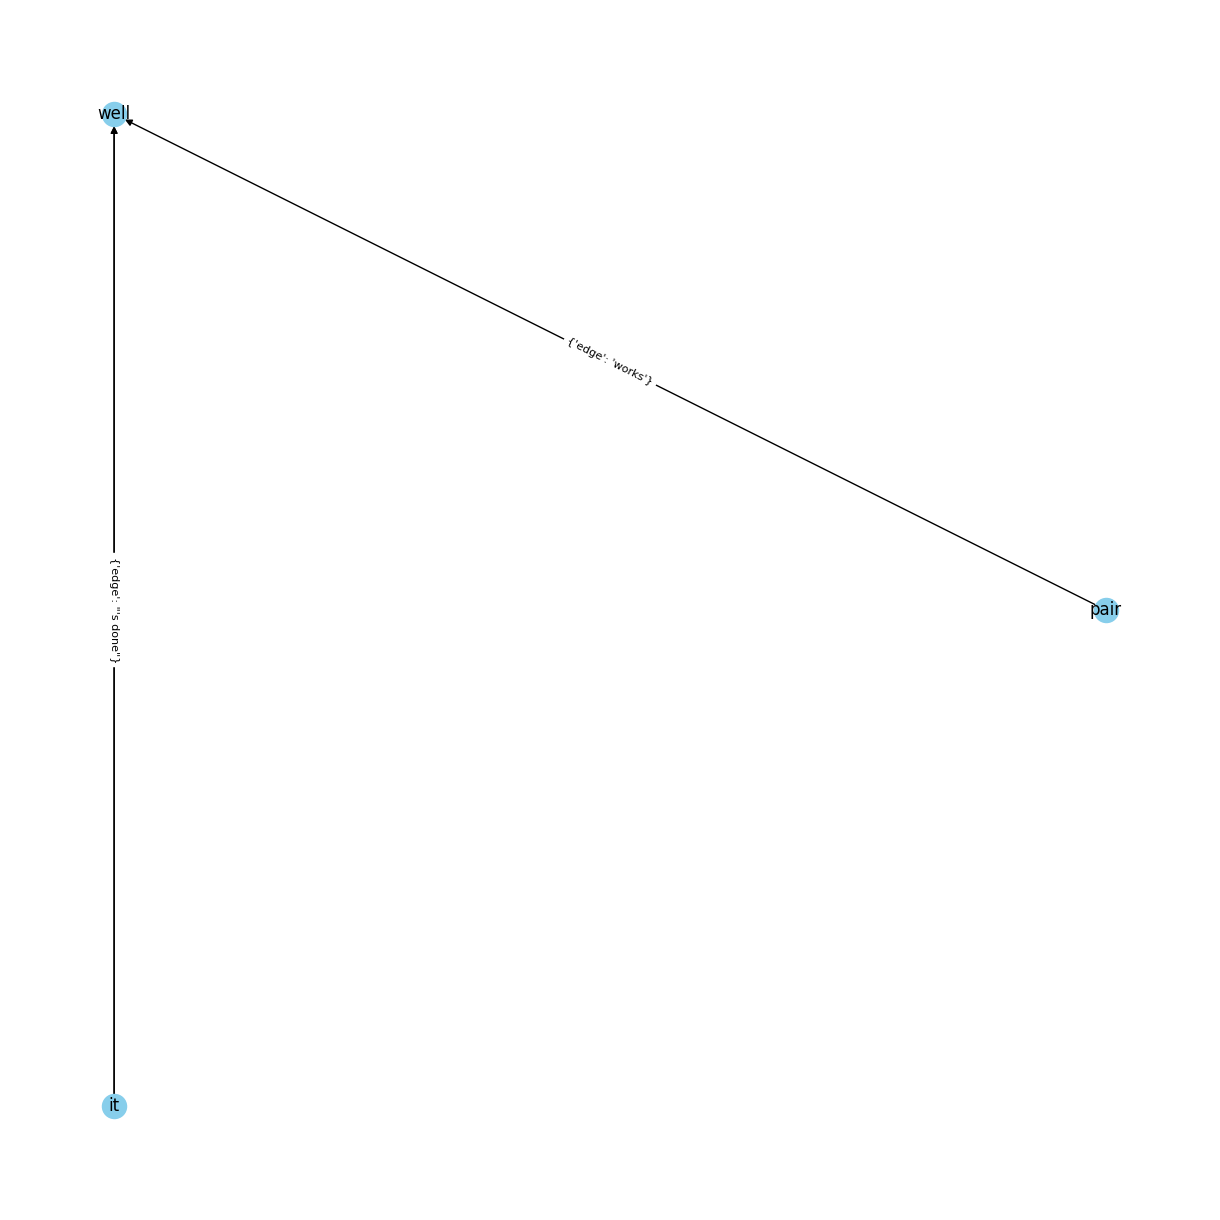

Plotting knowledge graph of "edge" token "is":


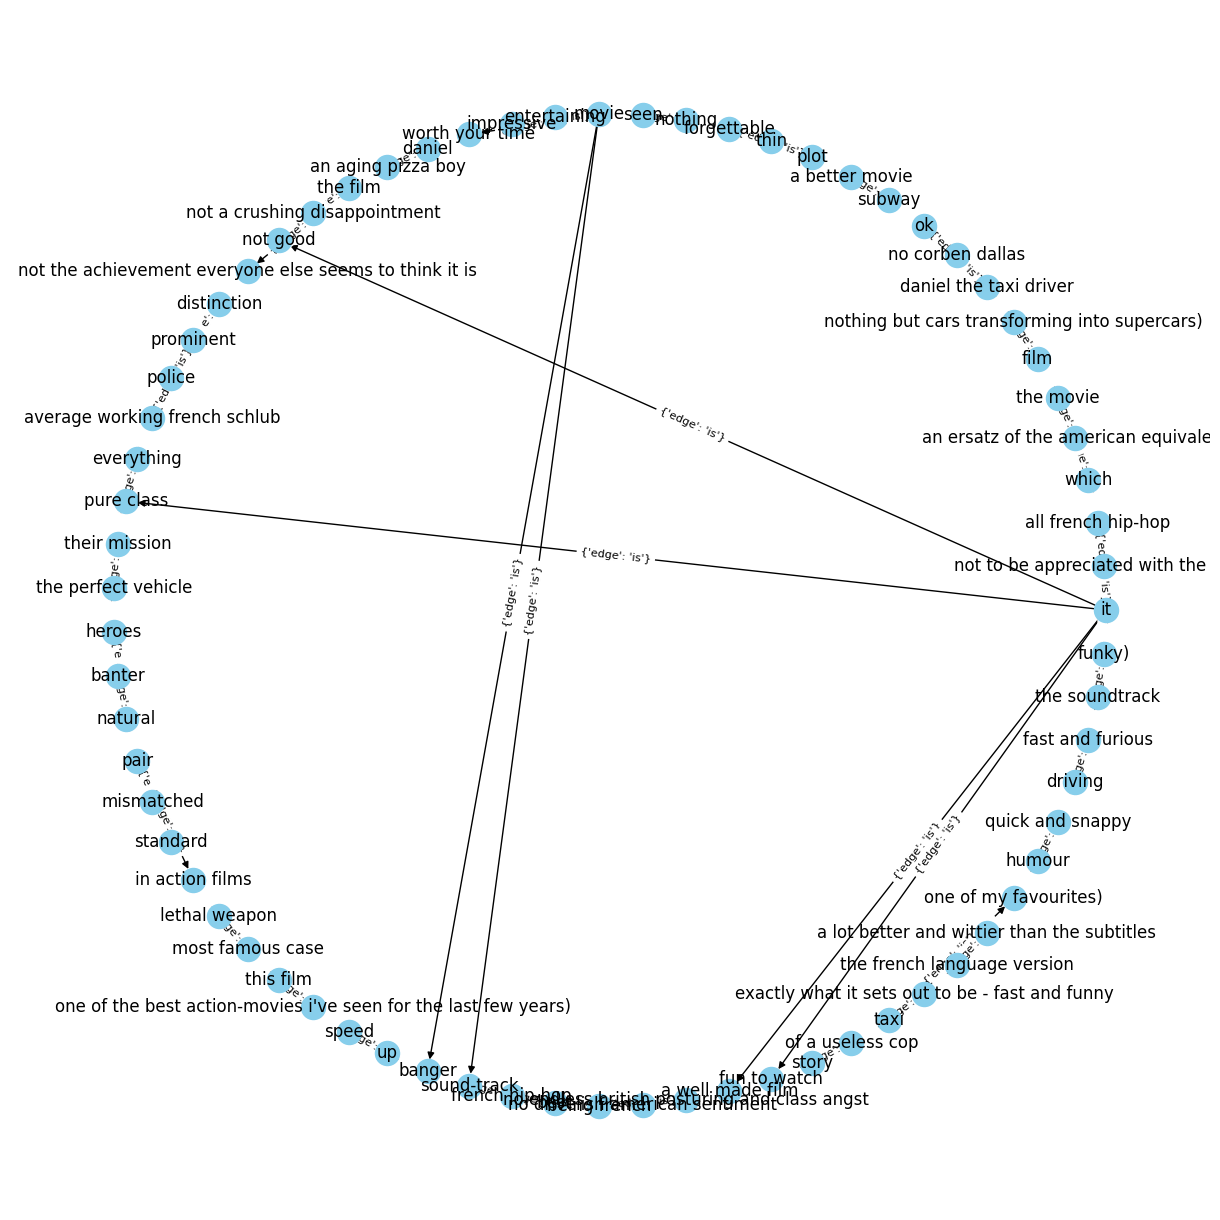

Plotting knowledge graph of "edge" token "are":


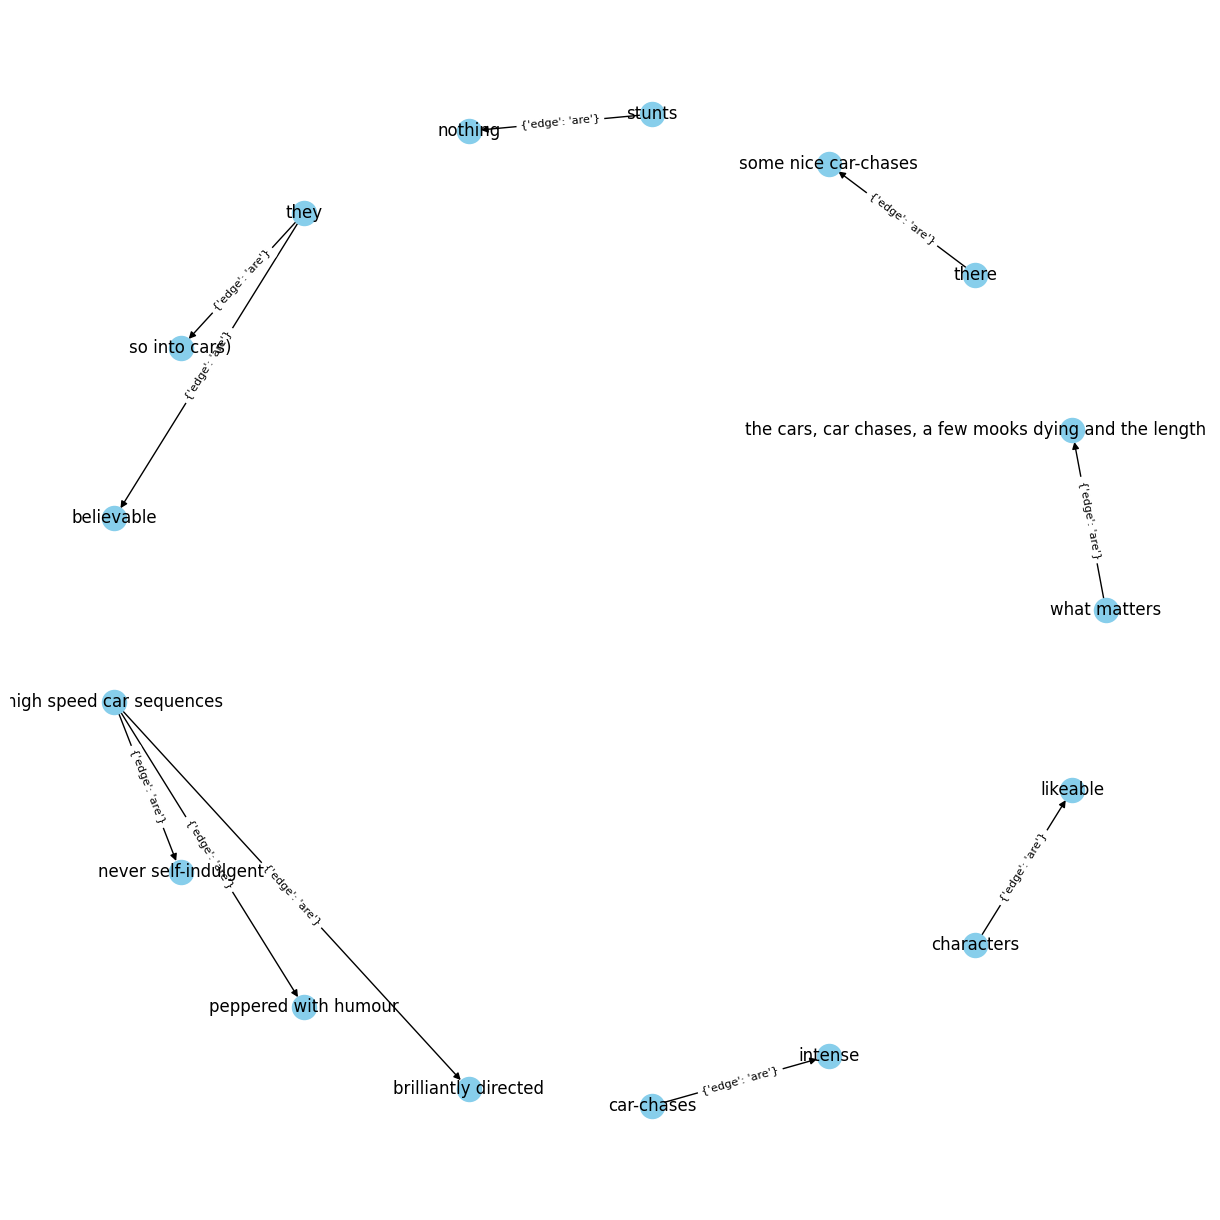

Plotting knowledge graph of "edge" token "has":


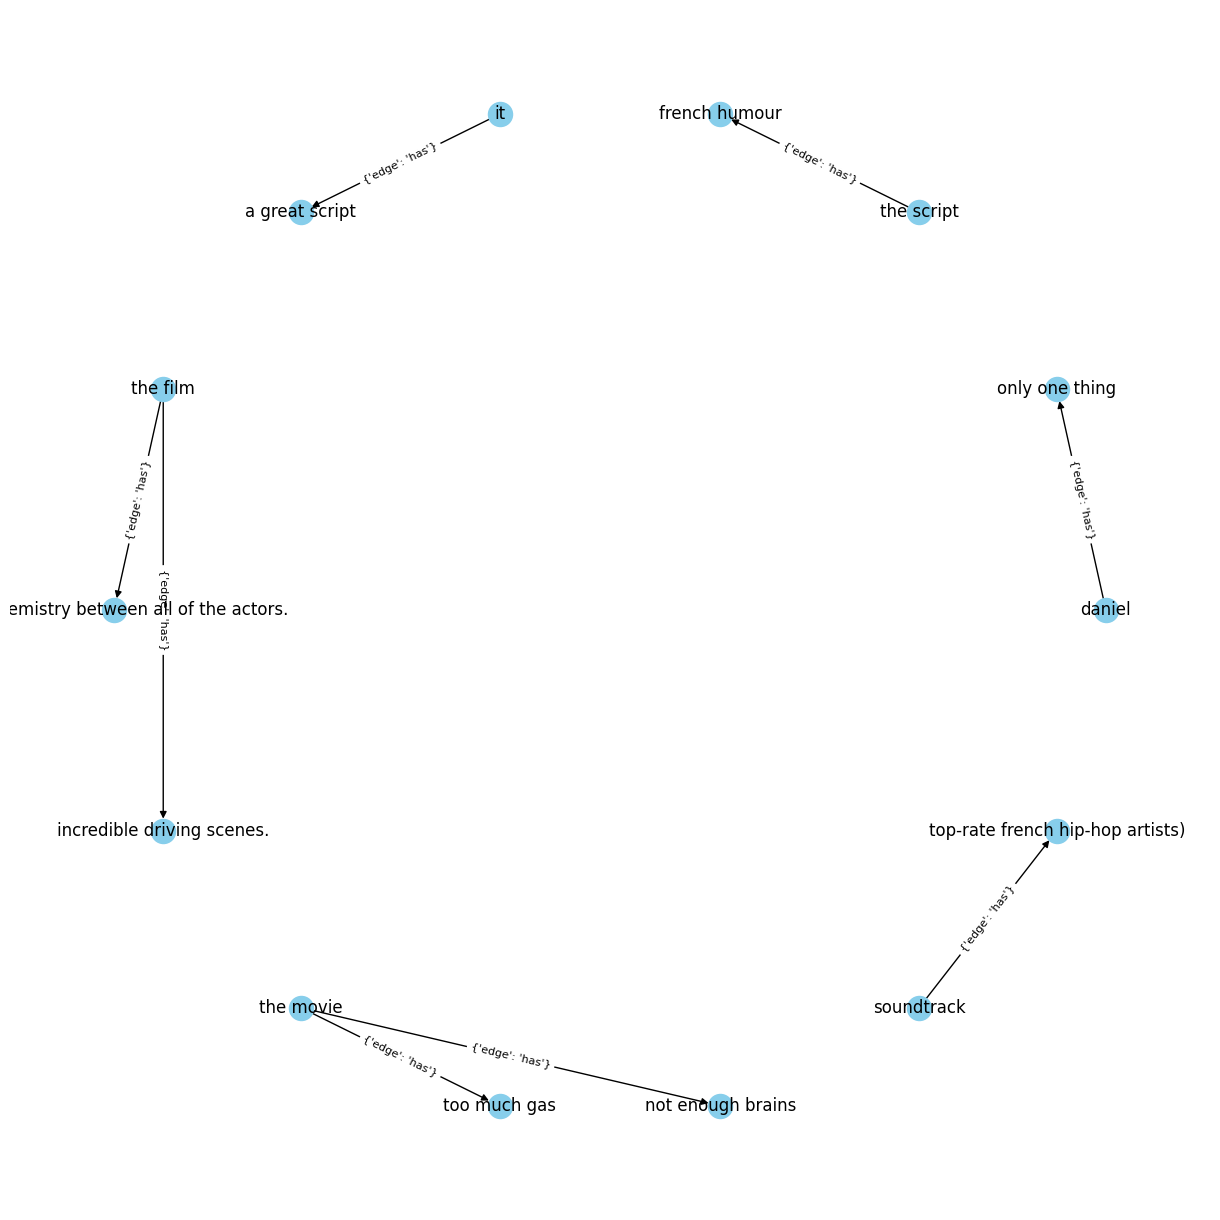

Plotting knowledge graph of "edge" token "have":


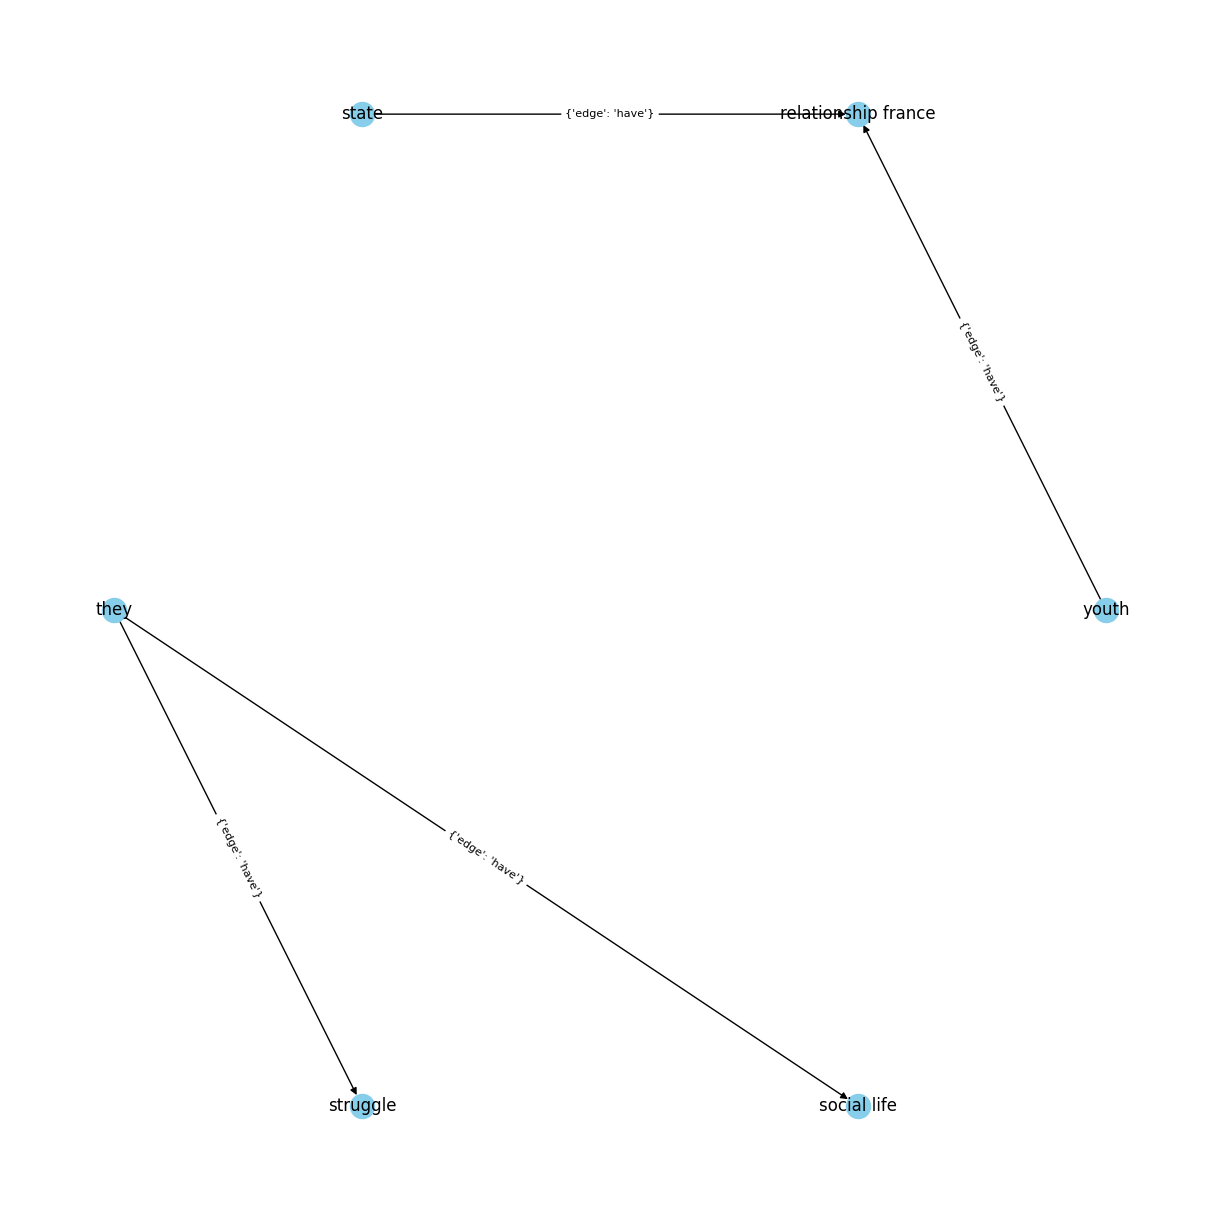

Plotting knowledge graph of "edge" token "come across as":


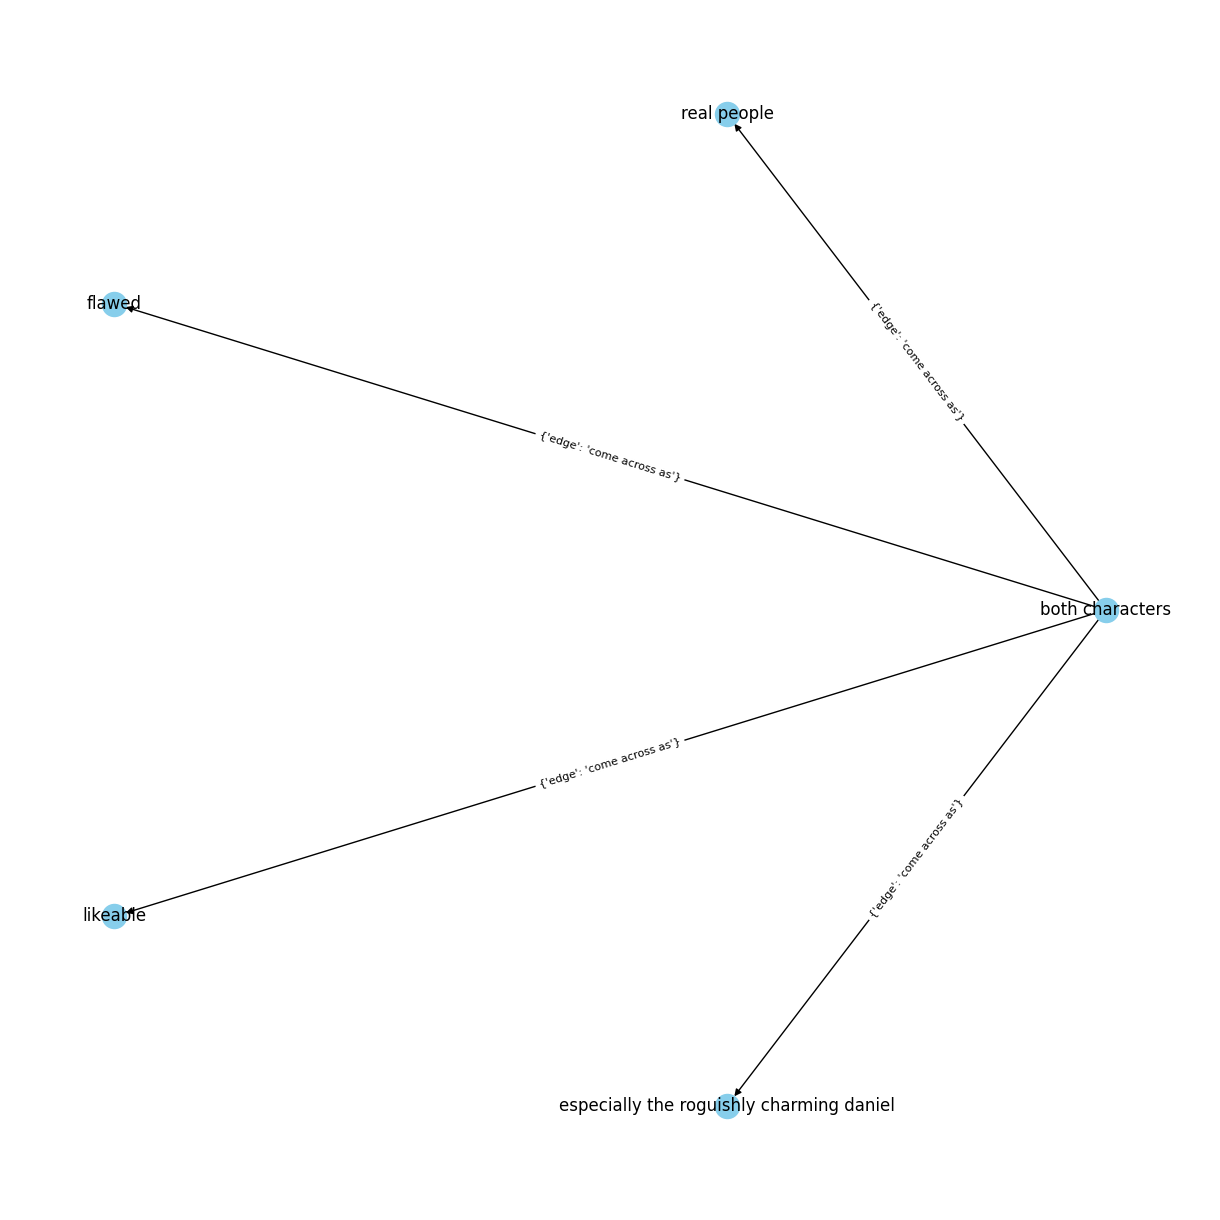

Plotting knowledge graph of "edge" token "verb":


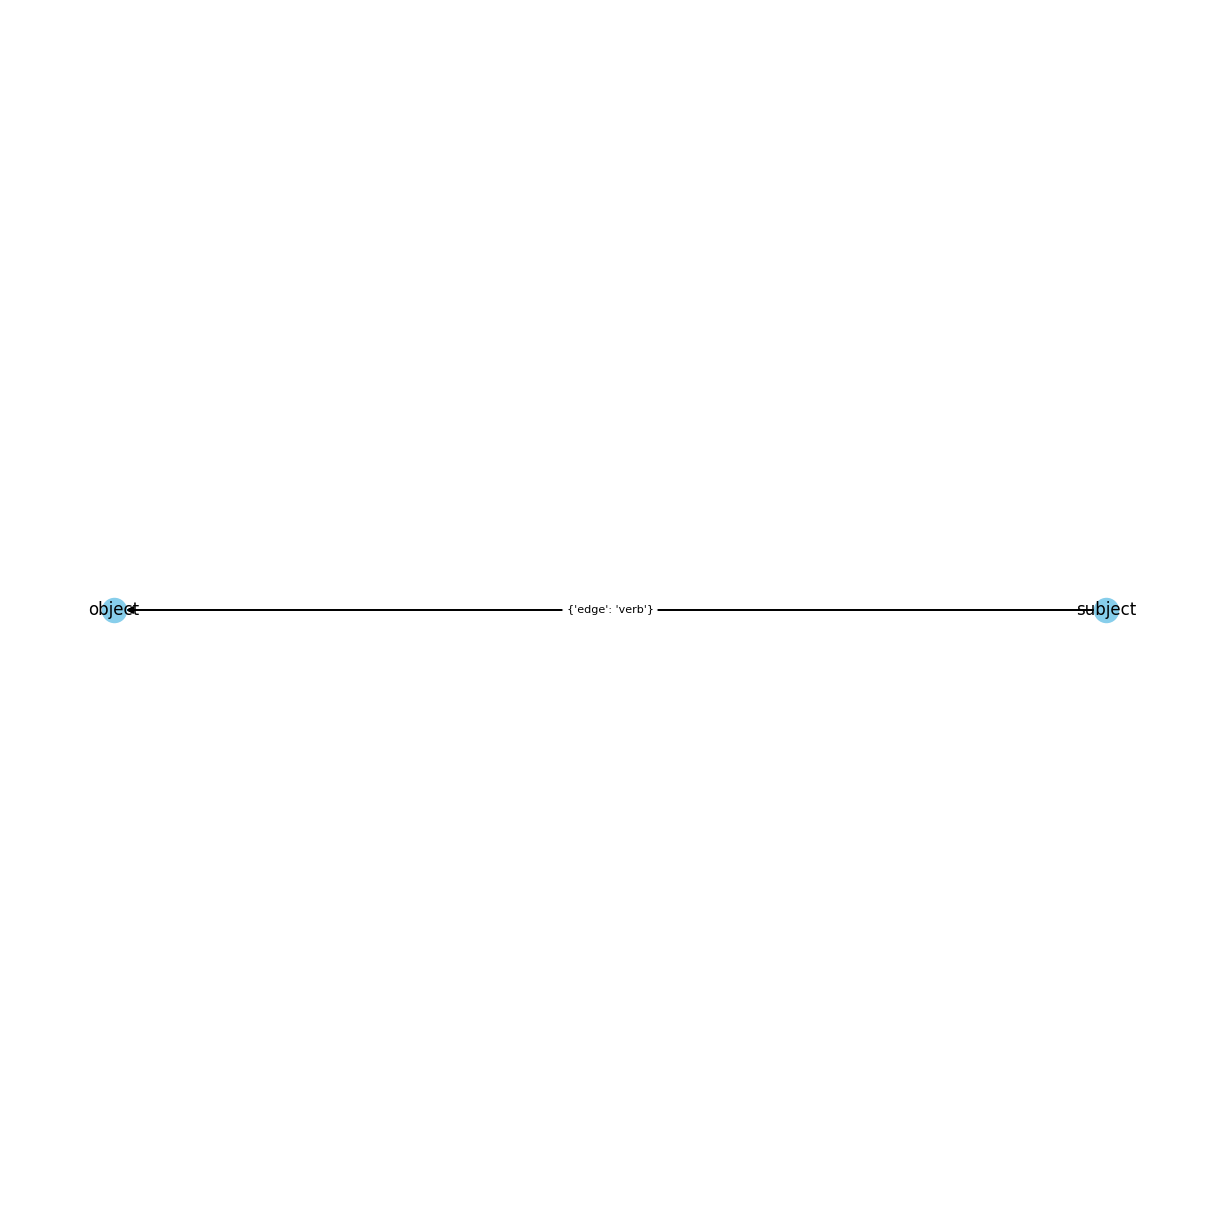

Plotting knowledge graph of "edge" token "was":


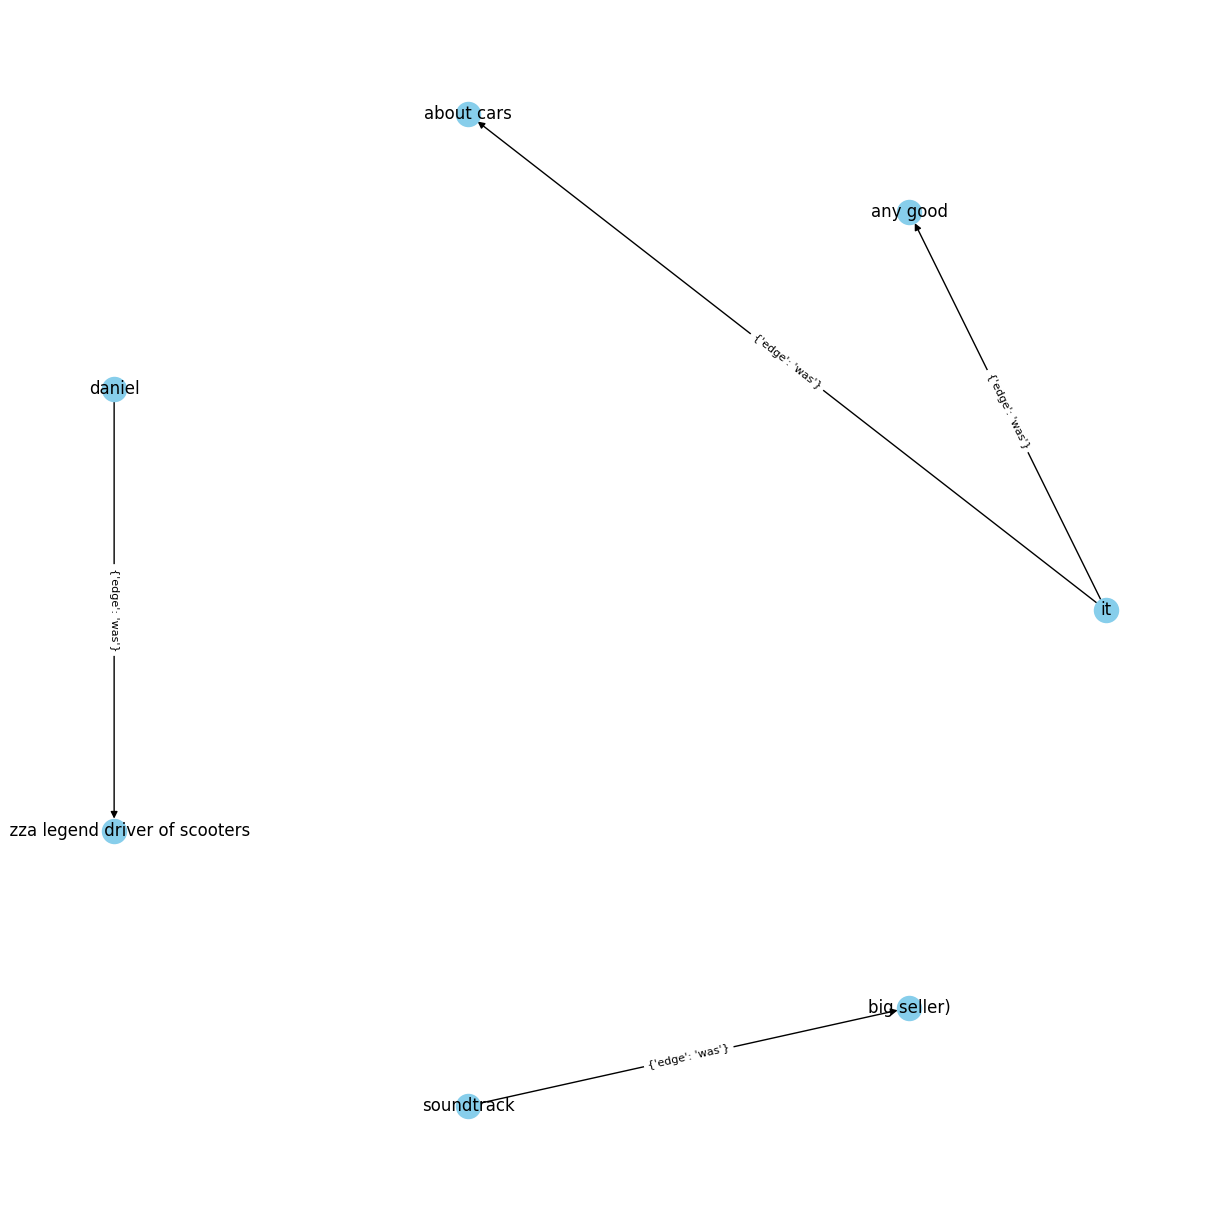

Plotting knowledge graph of "edge" token "coming across as":


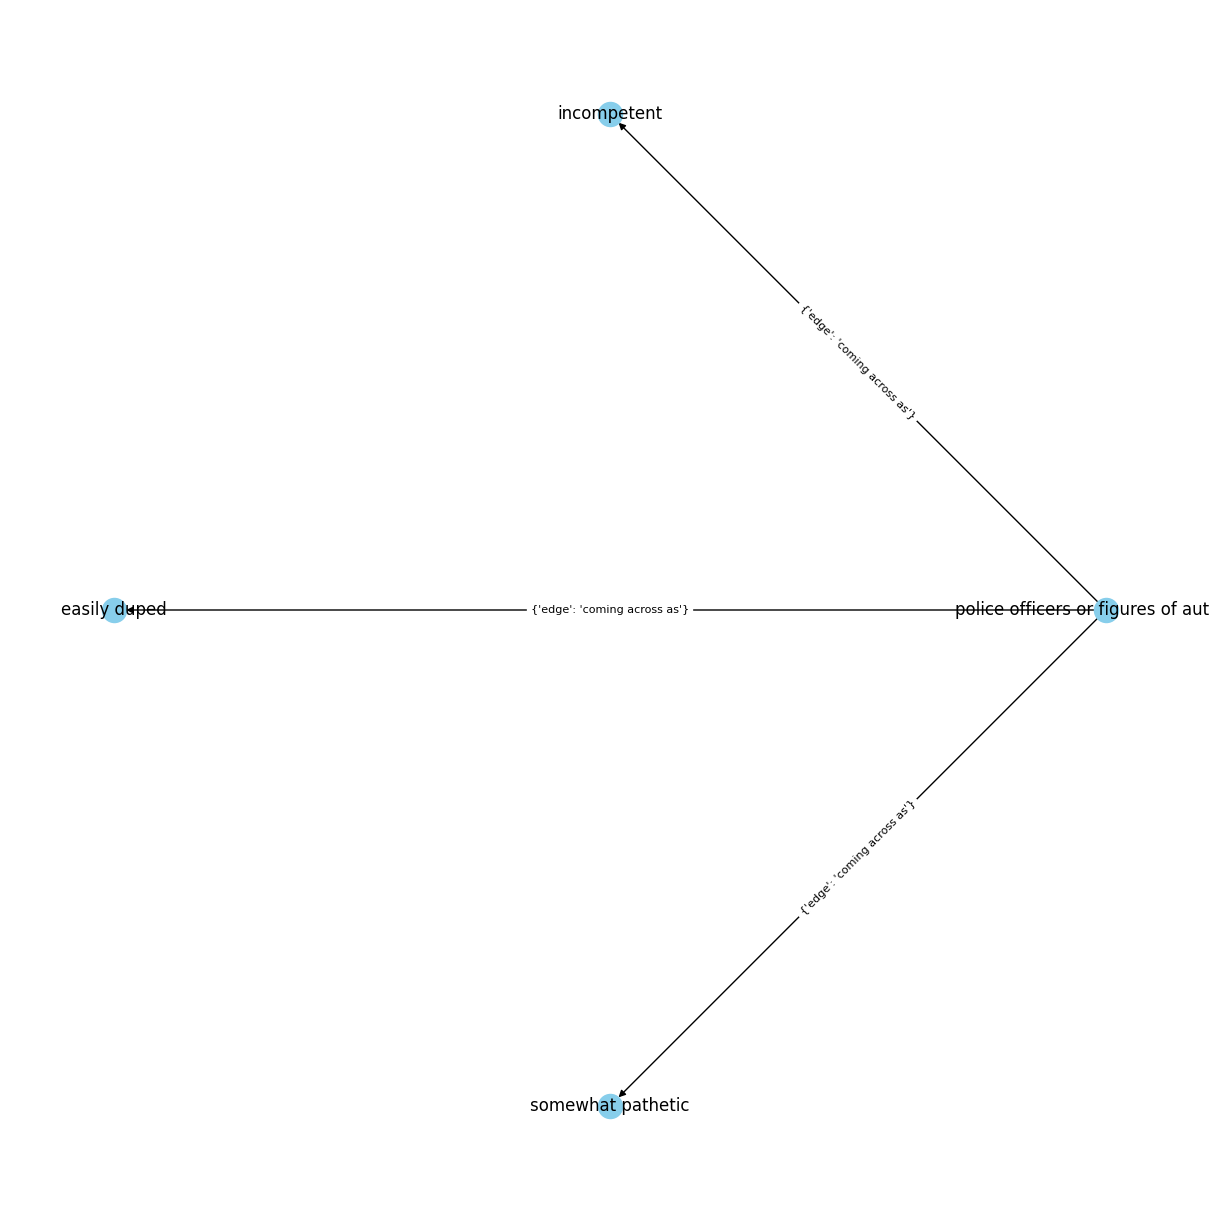

Plotting knowledge graph of "edge" token "ranges":


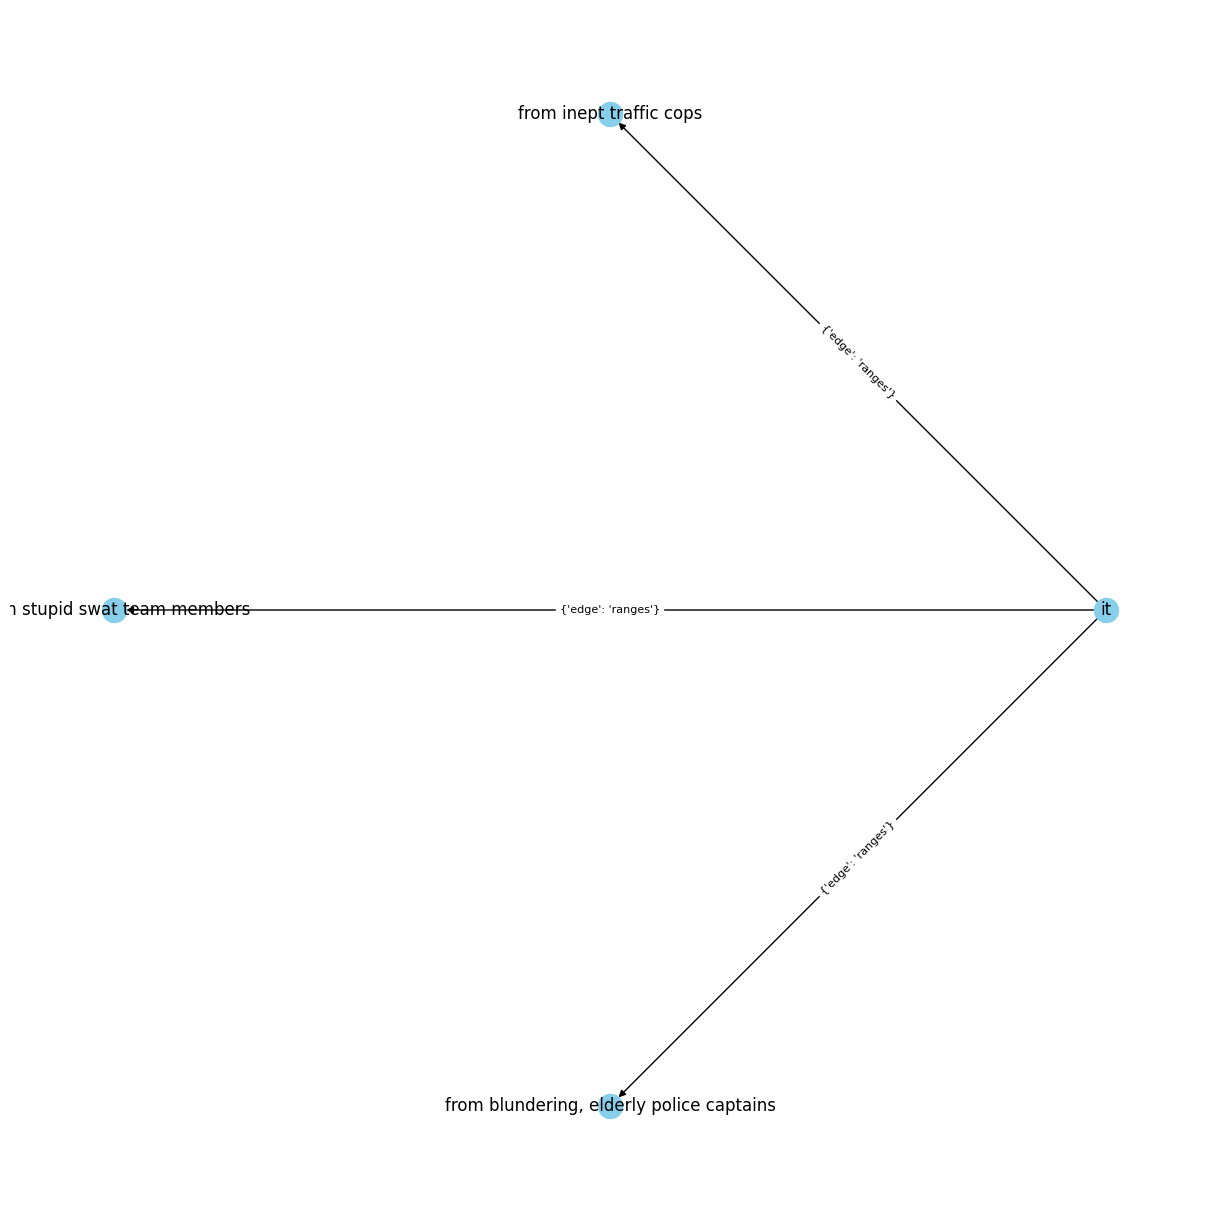

Plotting knowledge graph of "edge" token "want":


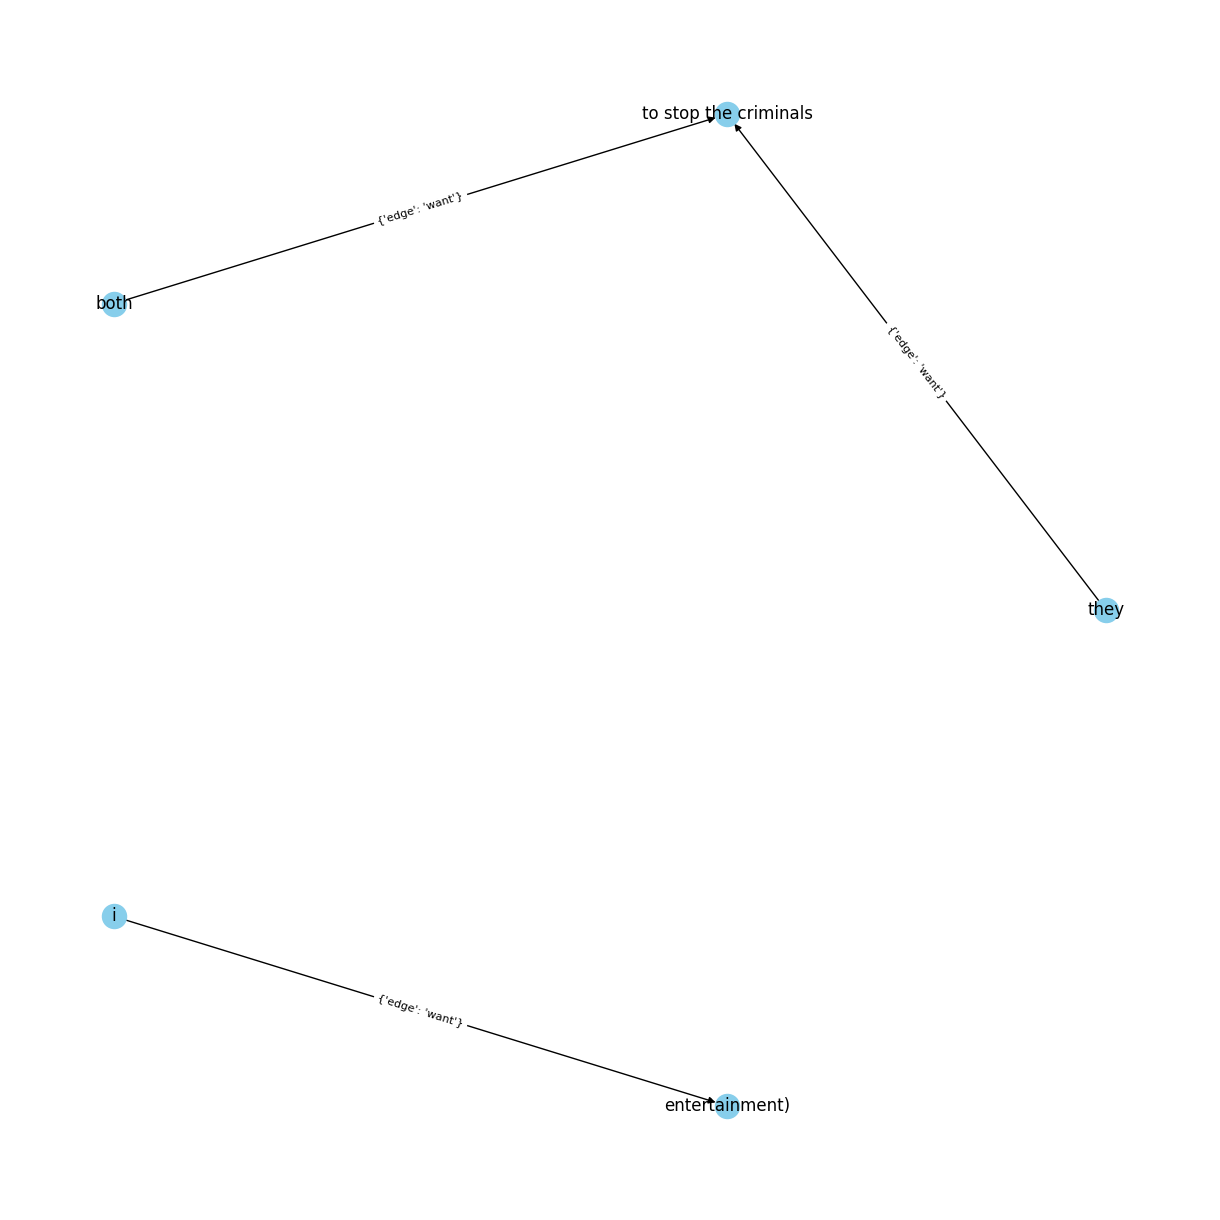

In [30]:
subset_item_list = ['source', 'target', 'edge']
no_of_sub_items = 10
for subset in subset_item_list:
  for key in kg_df[subset].value_counts().keys()[:no_of_sub_items].tolist():
    print(f"Plotting knowledge graph of \"{subset}\" token \"{key}\":")
    subset_df = kg_df[kg_df[subset]==key]
    plot_graph(subset_df, use_circular=True, show_edges=True)